# Gestor de EDAs inicials 

Aquest Notebook pretén desenvolupar una classe que permeti automatitzar la inspecció de l'evolució dels beneficis de les màquines, així com altres classes per investigar diferents variables dels JSONS dels quals tenim informació. Per a fer qualsevol dels dos casos, les dades han sigut prèviament tractades i separades en màquines, i s'ha realitzat una petita inspecció de les diferències entre els missatges JSON dels missatges tipus 25 que envien les diferents màquines. 

## 0. Importar i carregar llibreries

In [2]:
import os
import csv
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import *

## 1. Estadístiques bàsiques

In [ ]:
columns= [
    "ID", "MsgID", "FechaMensaje", "ReqID", "SgID", "Maquina", "SGVer",
    "ConexionTipoID", "MensajeTipoID", "Mensaje", "FechaModificacion", "UsuarioModificacion"
]
df = pd.read_csv('data/NPG3.133899.24.csv', sep=';', names=columns, header=None)
df.head()

,ID,MsgID,FechaMensaje,ReqID,SgID,Maquina,SGVer,ConexionTipoID,MensajeTipoID,Mensaje,FechaModificacion,UsuarioModificacion
0,102176610,754,2025-10-06 19:05:33.000,0,202481598327296,NPG3.133899.24,1.12.14-37,1,25,"{""TotalAccount"": {""Bet"": 2343650, ""Win"": 18355...",2025-10-06 21:05:40.287,golondrina
1,102176910,757,2025-10-06 19:07:33.000,0,202481598327296,NPG3.133899.24,1.12.14-37,1,25,"{""TotalAccount"": {""Bet"": 2344150, ""Win"": 18355...",2025-10-06 21:07:40.457,golondrina
2,102177059,759,2025-10-06 19:08:33.000,0,202481598327296,NPG3.133899.24,1.12.14-37,1,25,"{""TotalAccount"": {""Bet"": 2344150, ""Win"": 18355...",2025-10-06 21:08:40.600,golondrina
3,102177209,761,2025-10-06 19:09:33.000,0,202481598327296,NPG3.133899.24,1.12.14-37,1,25,"{""TotalAccount"": {""Bet"": 2344150, ""Win"": 18355...",2025-10-06 21:09:40.720,golondrina
4,102177353,763,2025-10-06 19:10:33.000,0,202481598327296,NPG3.133899.24,1.12.14-37,1,25,"{""TotalAccount"": {""Bet"": 2344150, ""Win"": 18355...",2025-10-06 21:10:40.860,golondrina


In [ ]:
# Basic df statistics
print("DataFrame Statistics:")E
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values per column:\n{df.isnull().sum()}")
print(f"Data types:\n{df.dtypes}")

DataFrame Statistics:
Number of rows: 2241
Number of columns: 14
Columns: ['ID', 'MsgID', 'FechaMensaje', 'ReqID', 'SgID', 'Maquina', 'SGVer', 'ConexionTipoID', 'MensajeTipoID', 'Mensaje', 'FechaModificacion', 'UsuarioModificacion', 'Missatge_json', 'Claus_json']
Missing values per column:
ID                     0
MsgID                  0
FechaMensaje           0
ReqID                  0
SgID                   0
Maquina                0
SGVer                  0
ConexionTipoID         0
MensajeTipoID          0
Mensaje                0
FechaModificacion      0
UsuarioModificacion    0
Missatge_json          0
Claus_json             0
dtype: int64
Data types:
ID                      int64
MsgID                   int64
FechaMensaje           object
ReqID                   int64
SgID                    int64
Maquina                object
SGVer                  object
ConexionTipoID          int64
MensajeTipoID           int64
Mensaje                object
FechaModificacion      object
Usua

## 2. Tractament JSON

Convertim el JSON a diccionari

In [10]:

def parse_json(mensaje):
    try:
        return json.loads(mensaje)
    except json.JSONDecodeError as e:
        print(f"Error en fila: {mensaje[:100]}... → {e}")
        return None

df['Missatge_json'] = df['Mensaje'].apply(parse_json)
df['Missatge_json'].head()

0    {'TotalAccount': {'Bet': 2343650, 'Win': 18355...
1    {'TotalAccount': {'Bet': 2344150, 'Win': 18355...
2    {'TotalAccount': {'Bet': 2344150, 'Win': 18355...
3    {'TotalAccount': {'Bet': 2344150, 'Win': 18355...
4    {'TotalAccount': {'Bet': 2344150, 'Win': 18355...
Name: Missatge_json, dtype: object

Obrim un exemple de JSON per analitzar-lo

In [ ]:
import pprint
pprint.pprint(df['Missatge_json'].iloc[0])

{'MultiGameAccount': {'MultiGameMeters': [{'GameId': 1,
                                           'GameName': 'Lord of the Ocean',
                                           'PartBet': 28353,
                                           'PartGames': 775,
                                           'PartWin': 42020,
                                           'TotalBet': 716913,
                                           'TotalGames': 24208,
                                           'TotalWin': 1259270},
                                          {'GameId': 2,
                                           'GameName': 'Book of Ra Deluxe',
                                           'PartBet': 40700,
                                           'PartGames': 1432,
                                           'PartWin': 68580,
                                           'TotalBet': 2066923,
                                           'TotalGames': 70881,
                                           'Total

Podem observar que, per aquesta màquina tenim 19 jocs diferents i cadascun té el seu propi contador individual. 

Comprovem que el JSON té una estructura estable en tot el csv

In [ ]:
def get_main_keys(json_obj):
    if isinstance(json_obj, dict):
        return tuple(sorted(json_obj.keys()))
    return None

df['Claus_json'] = df['Missatge_json'].apply(get_main_keys)

# Comprovem si totes les files tenen la mateixa estructura
estructura_consistent = df['Claus_json'].nunique() == 1
print(f"Totes les files tenen la mateixa estructura de claus principals?: {estructura_consistent}\n")

# si la estructura no és consistent, mostrem les diferents estructures trobades
if not estructura_consistent:
    claus_unicas = df['Claus_json'].unique()
    print("Estructures diferents trobades:")
    for claus in claus_unicas:
        print(claus)


Totes les files tenen la mateixa estructura de claus principals?: False

Estructures diferents trobades:
('MultiGameAccount', 'MultiSatAccount', 'PartAccount', 'PartAccountDetail', 'PartCash', 'PartCashDetail', 'PulseMeters', 'TimeTables', 'TotalAccount', 'TotalAccountDetail', 'TotalCash', 'TotalCashDetail', 'WarningMeters')
('Status', 'SystemInfo')
('Log',)
('Status',)


Observant el csv, veiem que no tots els missatges son de partides jugades. Per exemple, el 'Log' es el primer missatge del dia i dona la mateixa info que l'últim del dia anterior

Ignorem aquells missatges en els que no tenim els continguts "principals" i comprovem si s'ha reduït molt la mida. EL que trobo més fàcil és filtrar per aquells missatges que es donen en els jsons que no volem.

In [ ]:
unexpected_keys = ('Status', 'Log')
df_filtered = df[~df['Claus_json'].apply(lambda keys: any(key in unexpected_keys for key in keys))] 
df_unexpected = df[df['Claus_json'].apply(lambda keys: any(key in unexpected_keys for key in keys))]
print(f"Original number of rows: {df.shape[0]}")
print(f"Number of rows after filtering: {df_filtered.shape[0]}")
print(f"Number of rows with unexpected keys: {df_unexpected.shape[0]}")

Original number of rows: 2241
Number of rows after filtering: 2182
Number of rows with unexpected keys: 59


In [ ]:
def get_partaccount_keys(json_obj):
    if isinstance(json_obj, dict) and 'PartAccount' in json_obj:
        part_account = json_obj['PartAccount']
        if isinstance(part_account, dict):
            return tuple(sorted(part_account.keys()))
    return None
df_filtered['PartAccount_Claus'] = df_filtered['Missatge_json'].apply(get_partaccount_keys) 
estructura_partaccount_consistent = df_filtered['PartAccount_Claus'].nunique() == 1
print(f"\nTotes les files filtrades tenen la mateixa estructura de claus de 'PartAccount'?: {estructura_partaccount_consistent}\n")


Totes les files filtrades tenen la mateixa estructura de claus de 'PartAccount'?: True



Convertim les dades de PartAccount en columnes i netegem el dataframe

In [29]:
# extract the 'PartAccount' data into separate columns
#in the new df, inlcude only the columns extracted from the 'PartAccount' json, plus the Maquina, FechaModificacion and FechaMensaje columns from the original df_filtered
part_account_df = pd.json_normalize(df_filtered['Missatge_json'].apply(lambda x: x['PartAccount'] if isinstance(x, dict) and 'PartAccount' in x else {}))
df_pa = pd.concat([df_filtered[['Maquina', 'FechaModificacion', 'FechaMensaje']].reset_index(drop=True), part_account_df.reset_index(drop=True)], axis=1)
df_pa.head()

,Maquina,FechaModificacion,FechaMensaje,ResetDateTime,Bet,Win,Games,HandPay,TestBet,TestWin,TestGames,TestHandPay,TestMode,MeterEvents,CreditsIn,CreditsOut
0,NPG3.133899.24,2025-10-06 21:05:40.287,2025-10-06 19:05:33.000,2025-09-26T06:11:47,484150,314600,44570,0,0,0,0,0,False,0,1105865,936439
1,NPG3.133899.24,2025-10-06 21:07:40.457,2025-10-06 19:07:33.000,2025-09-26T06:11:47,484650,314600,44629,0,0,0,0,0,False,0,1106465,936533
2,NPG3.133899.24,2025-10-06 21:08:40.600,2025-10-06 19:08:33.000,2025-09-26T06:11:47,484650,314600,44632,0,0,0,0,0,False,0,1106525,938563
3,NPG3.133899.24,2025-10-06 21:09:40.720,2025-10-06 19:09:33.000,2025-09-26T06:11:47,484650,314600,44639,0,0,0,0,0,False,0,1106645,939443
4,NPG3.133899.24,2025-10-06 21:10:40.860,2025-10-06 19:10:33.000,2025-09-26T06:11:47,484650,314600,44660,0,0,0,0,0,False,0,1107085,939443


Ja tenim el dataframe final! 

## 3. EDA inicial

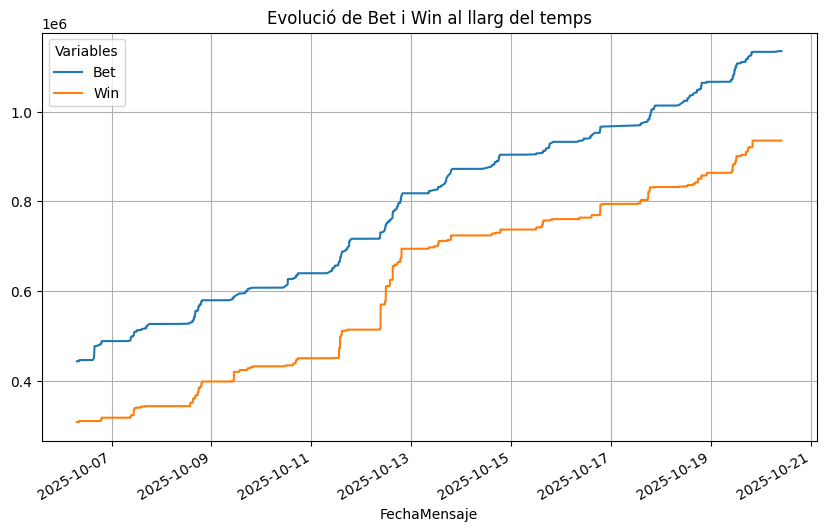

In [65]:
df_pa['FechaMensaje'] = pd.to_datetime(df_pa['FechaMensaje'], errors='coerce')
df_pa = df_pa.sort_values(by='FechaMensaje')
df_pa.plot(x='FechaMensaje', y=['Bet', 'Win'], kind='line', figsize=(10, 6))
plt.title('Evolució de Bet i Win al llarg del temps')
plt.xlabel('FechaMensaje')
plt.legend(title='Variables')
plt.grid()
plt.show()

<h2 style="color:#f39c12;"> Anàlisi de l'evolució de <em>Bet</em> i <em>Win</em></h2>

<p>Ja podem començar a observar que <strong>Bet</strong> i <strong>Win</strong> no evolucionen de manera paral·lela. A continuació, recordem què representen els paràmetres que estem analitzant:</p>

<ul style="list-style-type: square; padding-left: 20px;">
  <li><strong>Bet</strong>: <span style="color:#ecf0f1;">Contador de passos que han entrat desde l'última recaudació (o recàrrega). Els passos solen ser de 20 cts. </span></li>
  <li><strong>Win</strong>: <span style="color:#ecf0f1;">Contador de passos que han sortit desde l'última recaudació (o recàrrega)</span></li>
</ul>

<hr style="margin-top: 20px; margin-bottom: 20px;">

<p style=" color: #ecf0f1;">Ara podem fer algunes transformacions als valors per a conseguir el que realment busquem, l'evolució dels diners a la màquina. De moment només analitzem la diferència entre Bet i Win, que ens dona els beneficis de la màquina desde l'última recaudació. </p>

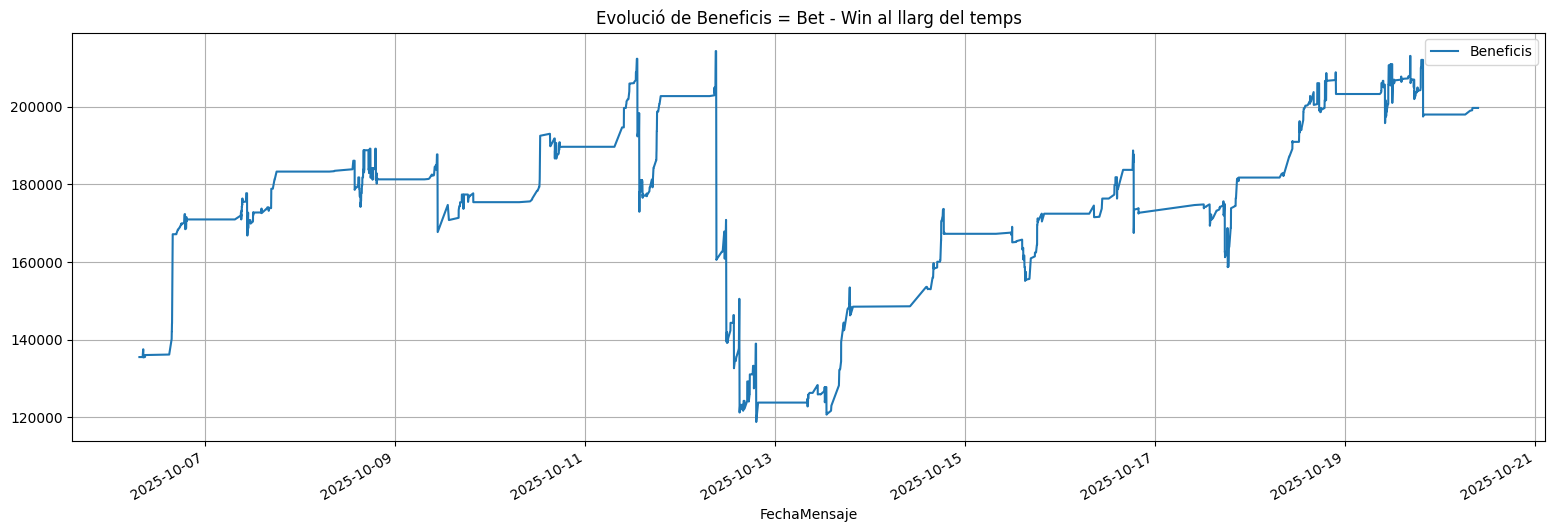

In [ ]:
df_pa['Beneficis']= df_pa['Bet'] - df_pa['Win']
df_pa.plot(x='FechaMensaje', y='Beneficis', kind='line', figsize=(19, 6))
#df_pa.plot(x='FechaMensaje', y='Credits', kind='line', figsize=(19, 6))
plt.title('Evolució de Beneficis = Bet - Win al llarg del temps')
plt.xlabel('FechaMensaje')
plt.grid()
plt.show()

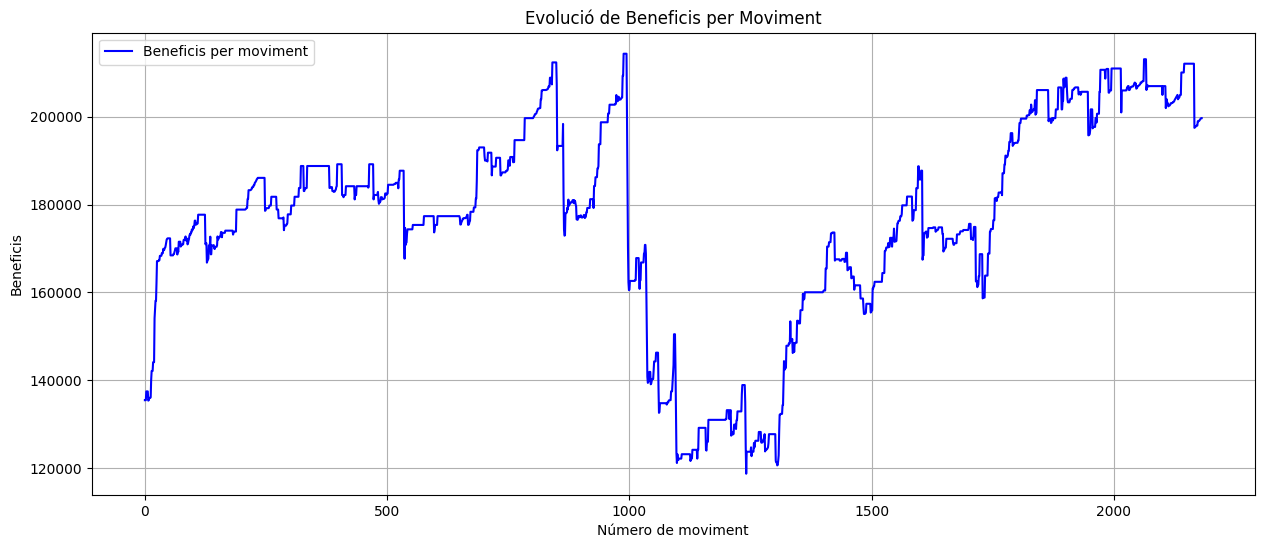

In [103]:
plt.figure(figsize=(15, 6))
plt.plot(df_pa.index, df_pa['Beneficis'], color='blue', label='Beneficis per moviment')
plt.title('Evolució de Beneficis per Moviment')
plt.xlabel('Número de moviment')
plt.ylabel('Beneficis')
plt.grid()
plt.legend()
plt.show()


Investiguem una mica la diferència entre CreditsIn, CreditsOut i Bet, Win

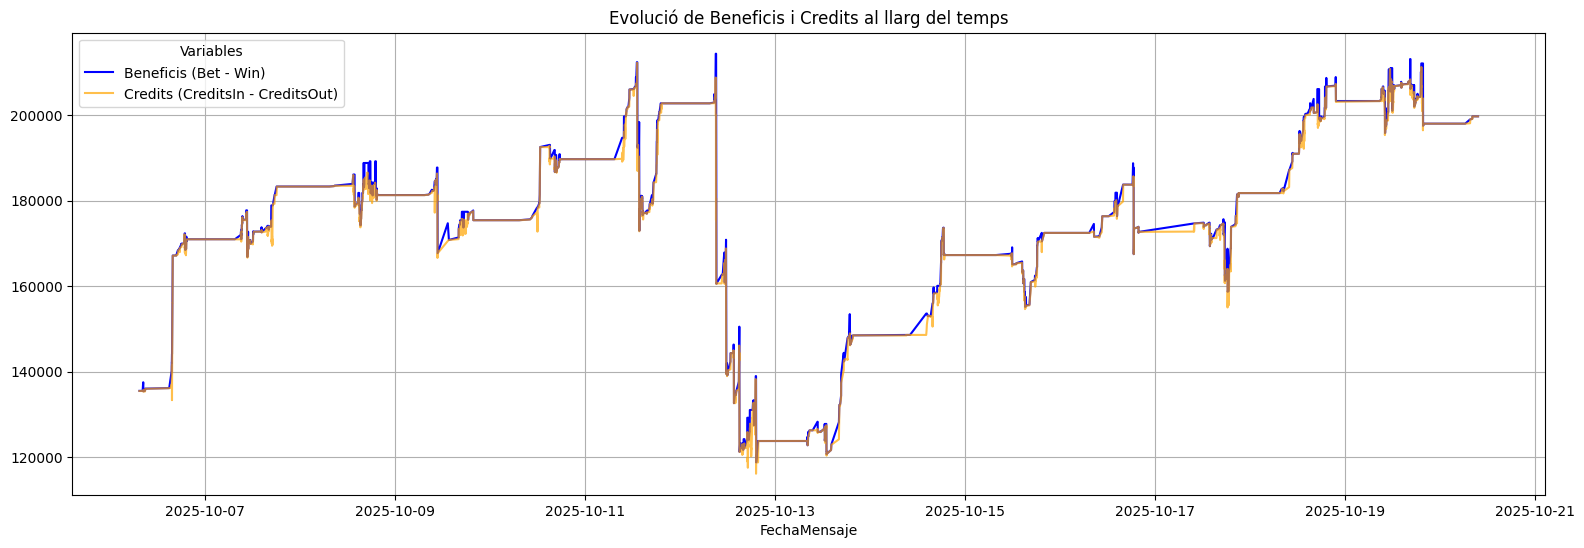

In [ ]:
df_pa['Credits']= df_pa['CreditsIn'] - df_pa['CreditsOut']
plt.figure(figsize=(19, 6))
plt.plot(df_pa['FechaMensaje'], df_pa['Beneficis'], label='Beneficis (Bet - Win)', color='blue')
plt.plot(df_pa['FechaMensaje'], df_pa['Credits'], label='Credits (CreditsIn - CreditsOut)', color='orange', alpha=0.7)
plt.title('Evolució de Beneficis i Credits al llarg del temps') 
plt.xlabel('FechaMensaje')
plt.legend(title='Variables')
plt.grid()
plt.show()


Podem observar que aquestes dues variables son molt similars però no en tot moment. De vegades difereixen breument i més tard tornen a ser iguals. He vsit al csv que en alguns dels missatges rebuts no canvia el Bet de PartAccount, només canvia el CreditsIn. No sé ben bé quina és la explicació per aixó. 

Les variables CreditsIn-Out tenen diferents valors a Bet-Win, però la diferència és la mateixa. 

In [ ]:
df_pa[['CreditsIn', 'CreditsOut','Credits', 'Bet', 'Win', 'Beneficis']].head(100) 

,CreditsIn,CreditsOut,Credits,Bet,Win,Beneficis
64,1037857,902398,135459,443450,307960,135490
116,1037857,902398,135459,443450,307960,135490
117,1037857,902398,135459,443450,307960,135490
142,1037857,902398,135459,445450,307960,137490
143,1038117,902414,135703,445450,307960,137490
...,...,...,...,...,...,...
18,1120665,947062,173603,495050,321400,173650
19,1120665,947062,173603,495050,321400,173650
20,1121345,947360,173985,495750,321400,174350
21,1121985,948020,173965,495950,321800,174150


Anem a investigar amb més profunditat la caiguda de Beneficis que s'observa al voltant del 13 d'octubre. No sembla una caiguda repentina donada per una desbancada, sino una serie consecutiva de premis entregats. 

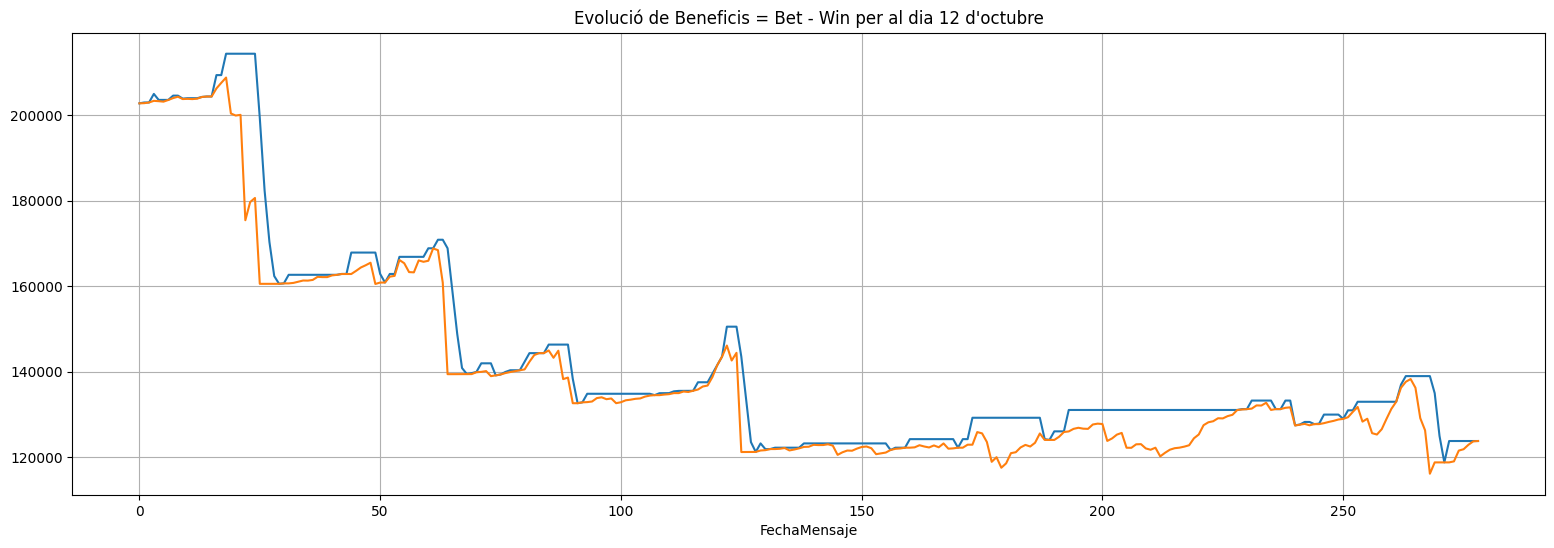

In [ ]:

df_caiguda = df_pa[(df_pa['FechaMensaje'] >= datetime(2025, 10, 12)) & (df_pa['FechaMensaje'] < datetime(2025, 10, 13))]
df_caiguda.reset_index(drop=True, inplace=True)

plt.figure(figsize=(19, 6))
plt.plot(df_caiguda.index, df_caiguda[['Beneficis', 'Credits']])
plt.title("Evolució de Beneficis i Credits per al dia 12 d'octubre")
plt.xlabel('FechaMensaje')
plt.grid()
plt.show()

Vist amb més granularitat, podem confirmar el que sospitavem. El 12 d'octubre s'encadena una ratxa de premis que fa perdre diners significativament a la màquina. 

Ara podem replicar el codi creat per moltes més màquines, de tal manera que poguem observar aquestes dades per múltiples màquines. Per fer-ho, el més efectiu es crear una classe que automatitzi el rentat i transformació d'un csv. 

## 4. Altres màquines

In [5]:
def parse_json(mensaje):
    try:
        return json.loads(mensaje)
    except json.JSONDecodeError as e:
        print(f"Error en fila: {mensaje[:100]}... → {e}")
        return None


def get_main_keys(json_obj):
    if isinstance(json_obj, dict):
        return tuple(sorted(json_obj.keys()))
    return None

In [ ]:
class EDAinicial:
    def __init__(self, filepath):
        """
        Classe per a fer un EDA inicial de fitxers de missatges. Aquesta classe segueix el següent procés:
        1. Carrega el fitxer CSV amb els missatges.
        2. Analitza la columna 'Mensaje' per extreure les claus principals dels objectes JSON.
        3. Filtra les files que contenen claus inesperades.
        4. Extreu les dades de 'PartAccount' en un DataFrame separat.
        5. Ordena les dades per 'FechaMensaje' i calcula les columnes 'Beneficis' i 'Credits'.
        6. Plotteja la evolució de 'Bet' i 'Win', així com 'Beneficis' i 'Credits' al llarg del temps i dels moviments.
        ---------------
        Args:
            filepath (str): Ruta al fitxer CSV amb els missatges d'una màquina concreta.

        """
        self.filepath = filepath
        self.df = None
        self.load_and_process_data()
    
    def load_and_process_data(self):
        
        self.df = pd.read_csv(self.filepath, sep=',')
        
        self.df['Missatge_json'] = self.df['Mensaje'].apply(parse_json)

        # only keep rows where 'MensajeTipoID' is 25
        self.df = self.df[self.df['MensajeTipoID'] == 25] # només missatges que contenen PartAccount
                      
        part_account_df = pd.json_normalize(self.df['Missatge_json'].apply(lambda x: x['PartAccount'] if isinstance(x, dict) and 'PartAccount' in x else {}))
        self.df = pd.concat([self.df[['Maquina', 'FechaModificacion', 'FechaMensaje']].reset_index(drop=True), part_account_df.reset_index(drop=True)], axis=1)
        
        self.df['FechaMensaje'] = pd.to_datetime(self.df['FechaMensaje'], errors='coerce')
        self.df = self.df.sort_values(by='FechaMensaje')
        self.df.reset_index(inplace=True)
        
        self.df['Beneficis']= self.df['Bet'] - self.df['Win']
        self.df['Credits']= self.df['CreditsIn'] - self.df['CreditsOut']


    def save_processed_data(self):
        """
        Desa el DataFrame processat en un fitxer CSV.
        
        """
        output_filepath = os.path.splitext(self.filepath)[0] + '_clean.csv'
        self.df.to_csv(output_filepath, index=False)
        print(f"Dades processades desades a: {output_filepath}")
        

    def plot_bet_win(self):
        """
        Genera un doble Plot en el que estudiarem la evolució de Bet i Win.
        Al primer plot veurem la evolució de Bet i Win al llarg del temps.
        Al segon plot veurem la evolució al llarg dels moviments.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19, 12))

        # Primer subplot: evolució al llarg del temps
        ax1.plot(self.df['FechaMensaje'], self.df['Bet'], label='Bet', color='blue')
        ax1.plot(self.df['FechaMensaje'], self.df['Win'], label='Win', color='orange')
        ax1.set_title('Evolució de Bet i Win al llarg del temps')
        ax1.set_xlabel('FechaMensaje')
        ax1.legend(title='Variables')
        ax1.grid()

        # Segon subplot: evolució al llarg dels moviments
        ax2.plot(self.df.index, self.df['Bet'], label='Bet', color='blue')
        ax2.plot(self.df.index, self.df['Win'], label='Win', color='orange')
        ax2.set_title(f'Evolució de Bet i Win al llarg dels {len(self.df)} moviments')
        ax2.set_xlabel('Número de moviment')
        ax2.legend(title='Variables')
        ax2.grid()

        plt.tight_layout()
        plt.show()
        

    def plot_beneficis_credits(self):
        """
        Genera un altre double plot en el que estudiarem la evolució de Beneficis i Credits.
        Al primer plot veurem la evolució de Beneficis i Credits al llarg del temps.
        Al segon plot veurem la evolució al llarg dels moviments. 
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19, 12))

        # Primer subplot: evolució al llarg del temps
        ax1.plot(self.df['FechaMensaje'], self.df['Beneficis'], label='Beneficis (Bet - Win)', color='blue')
        ax1.plot(self.df['FechaMensaje'], self.df['Credits'], label='Credits (CreditsIn - CreditsOut)', color='orange', alpha=0.7)
        ax1.set_title(f'Evolució de Beneficis i Credits al llarg del temps')
        ax1.set_xlabel('FechaMensaje')
        ax1.legend(title='Variables')
        ax1.grid()
        "blabla"

        # Segon subplot: evolució al llarg dels moviments
        ax2.plot(self.df.index, self.df['Beneficis'], label='Beneficis (Bet - Win)', color='blue')
        ax2.plot(self.df.index, self.df['Credits'], label='Credits (CreditsIn - CreditsOut)', color='orange', alpha=0.7)
        ax2.set_title(f'Evolució de Beneficis i Credits al llarg dels {len(self.df)} moviments')
        ax2.set_xlabel('Número de moviment')
        ax2.legend(title='Variables')
        ax2.grid()

        plt.tight_layout()
        plt.show()
        

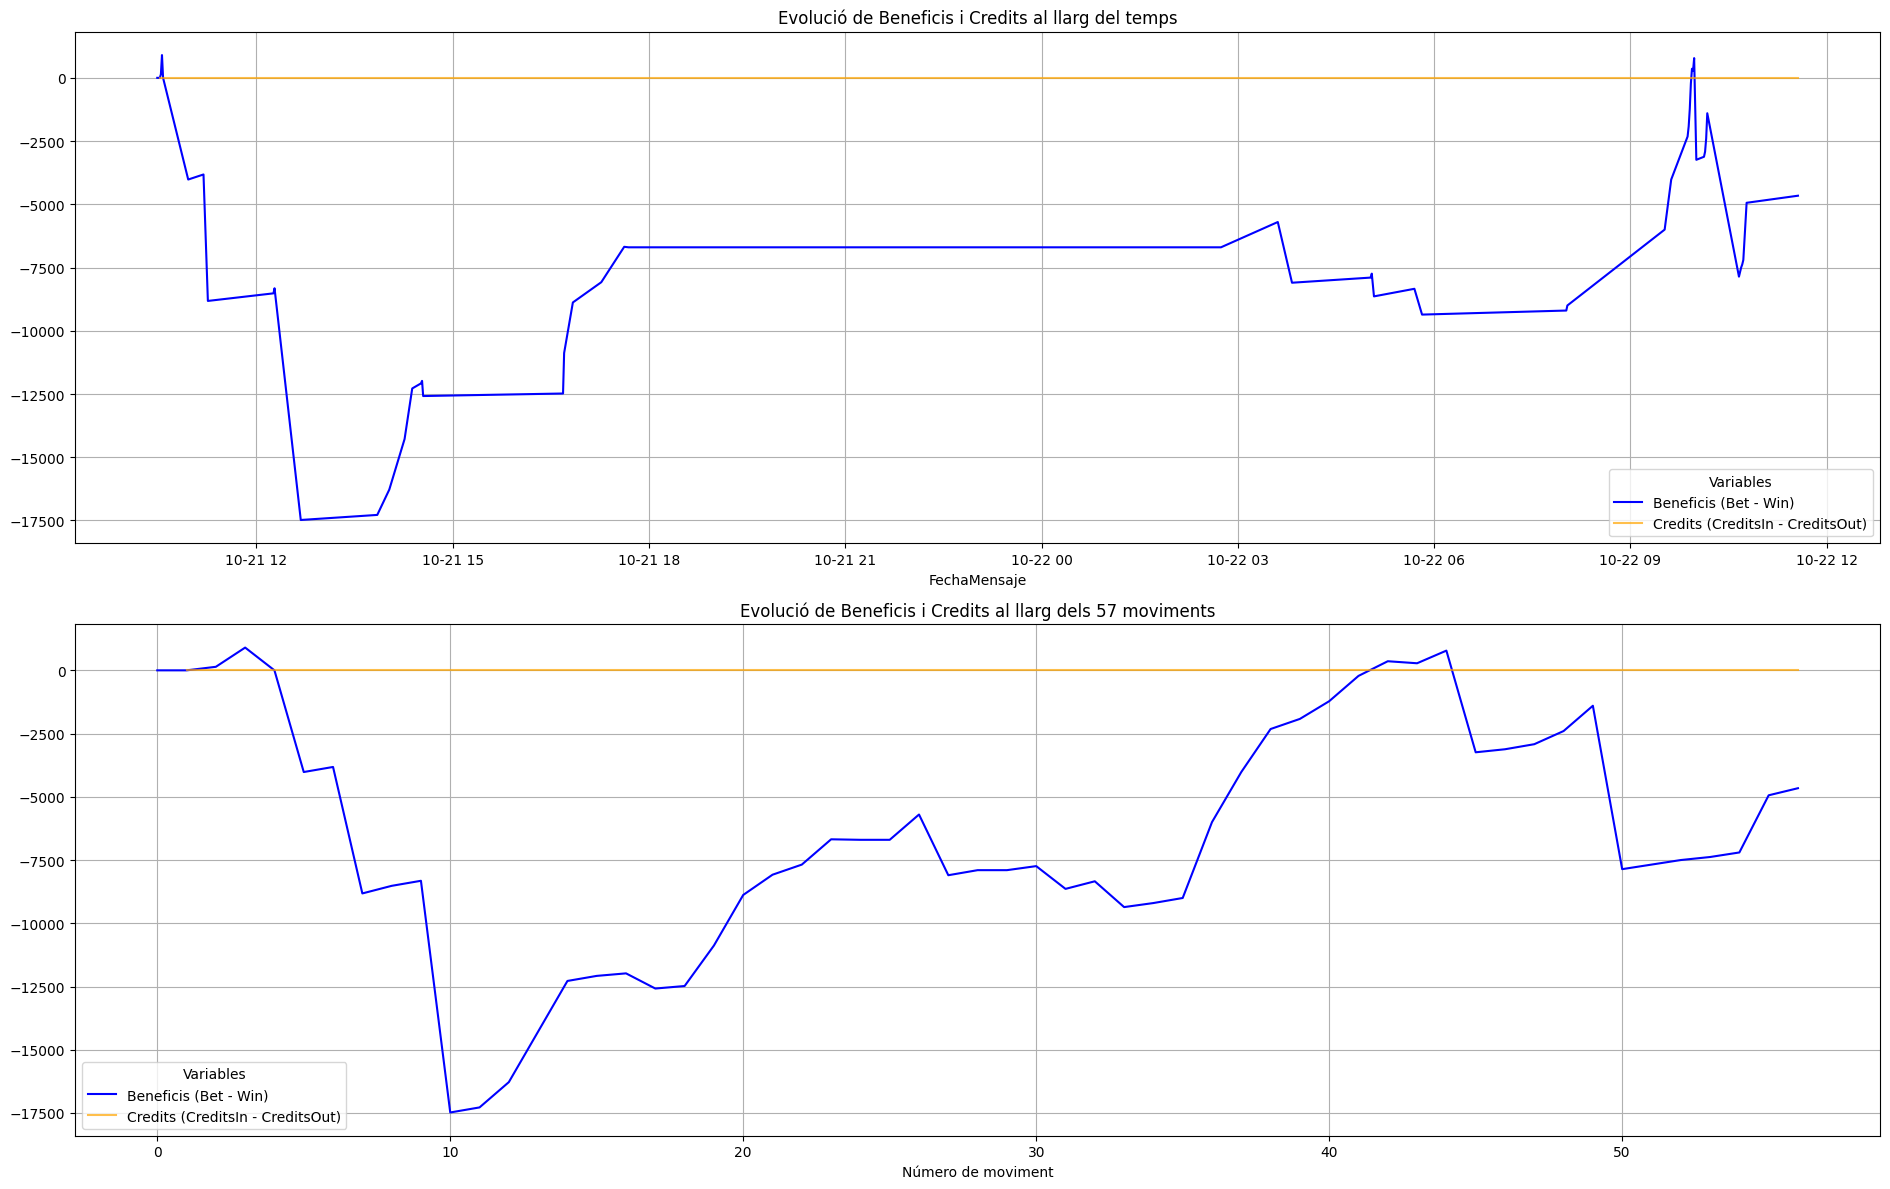

In [ ]:
dataset_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'Missatges_x_maquina', '7PO2.2033.25.csv')
test_eda = EDAinicial(dataset_path)
test_eda.plot_beneficis_credits()


Analitzant màquina: SEL2.2728.23.csv


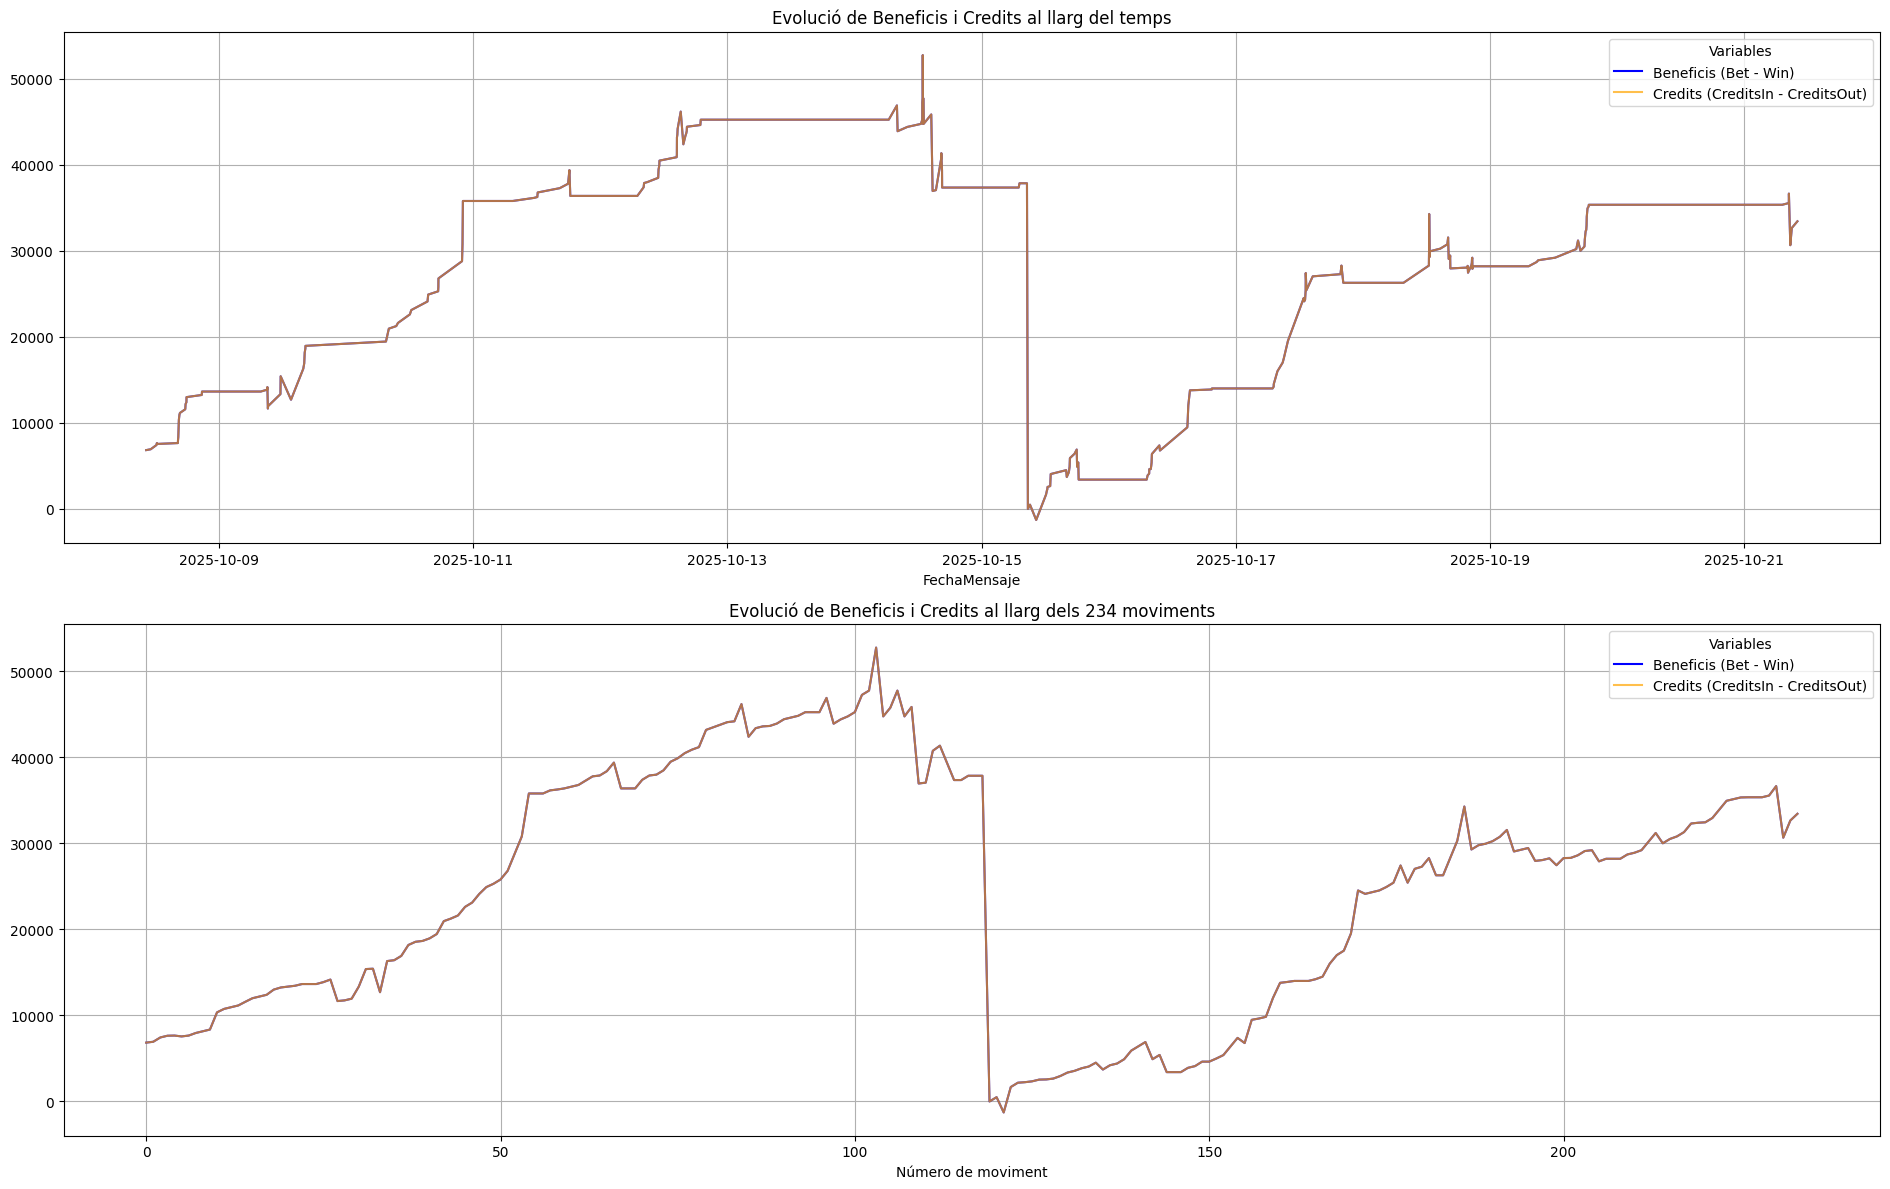


Analitzant màquina: NLX2.7235.23.csv


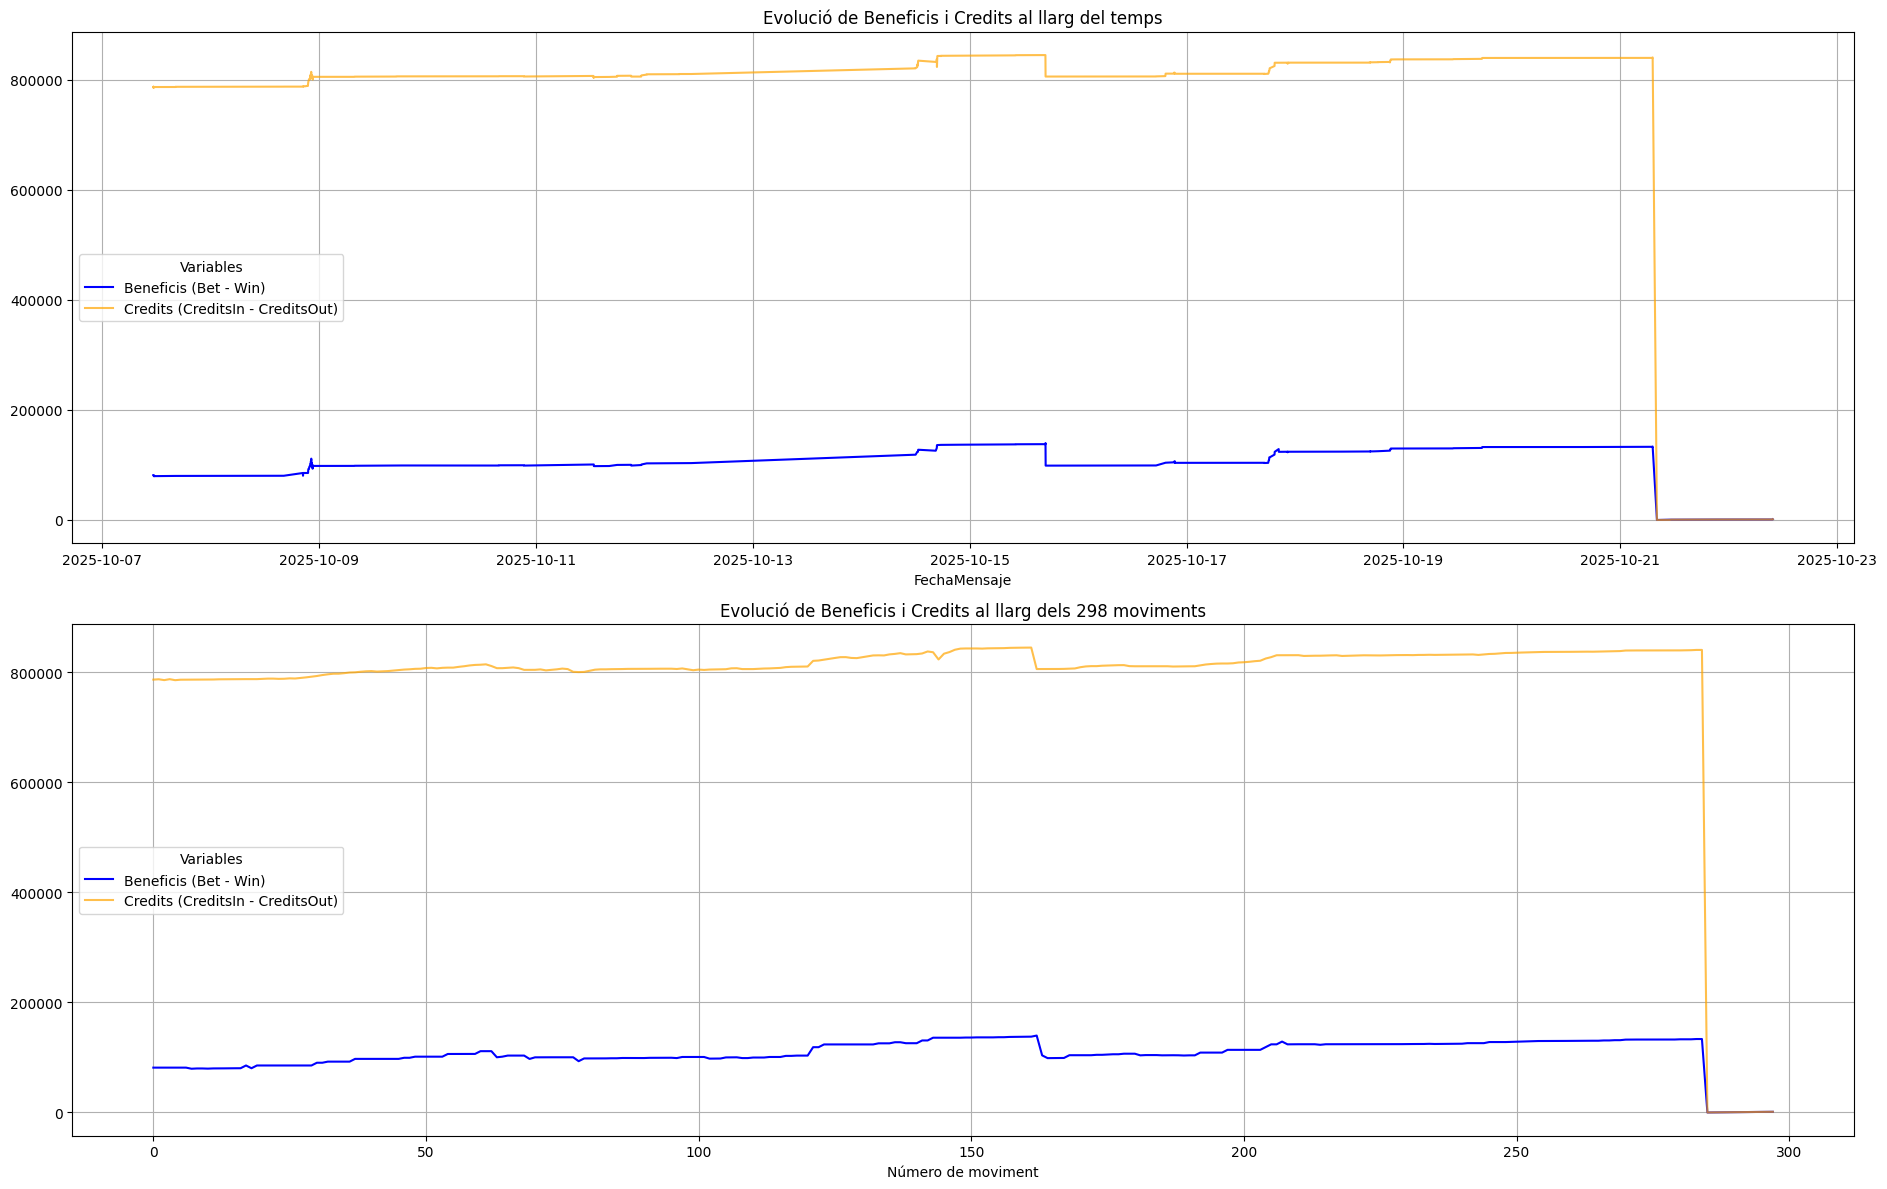


Analitzant màquina: NLX2.6582.25.csv


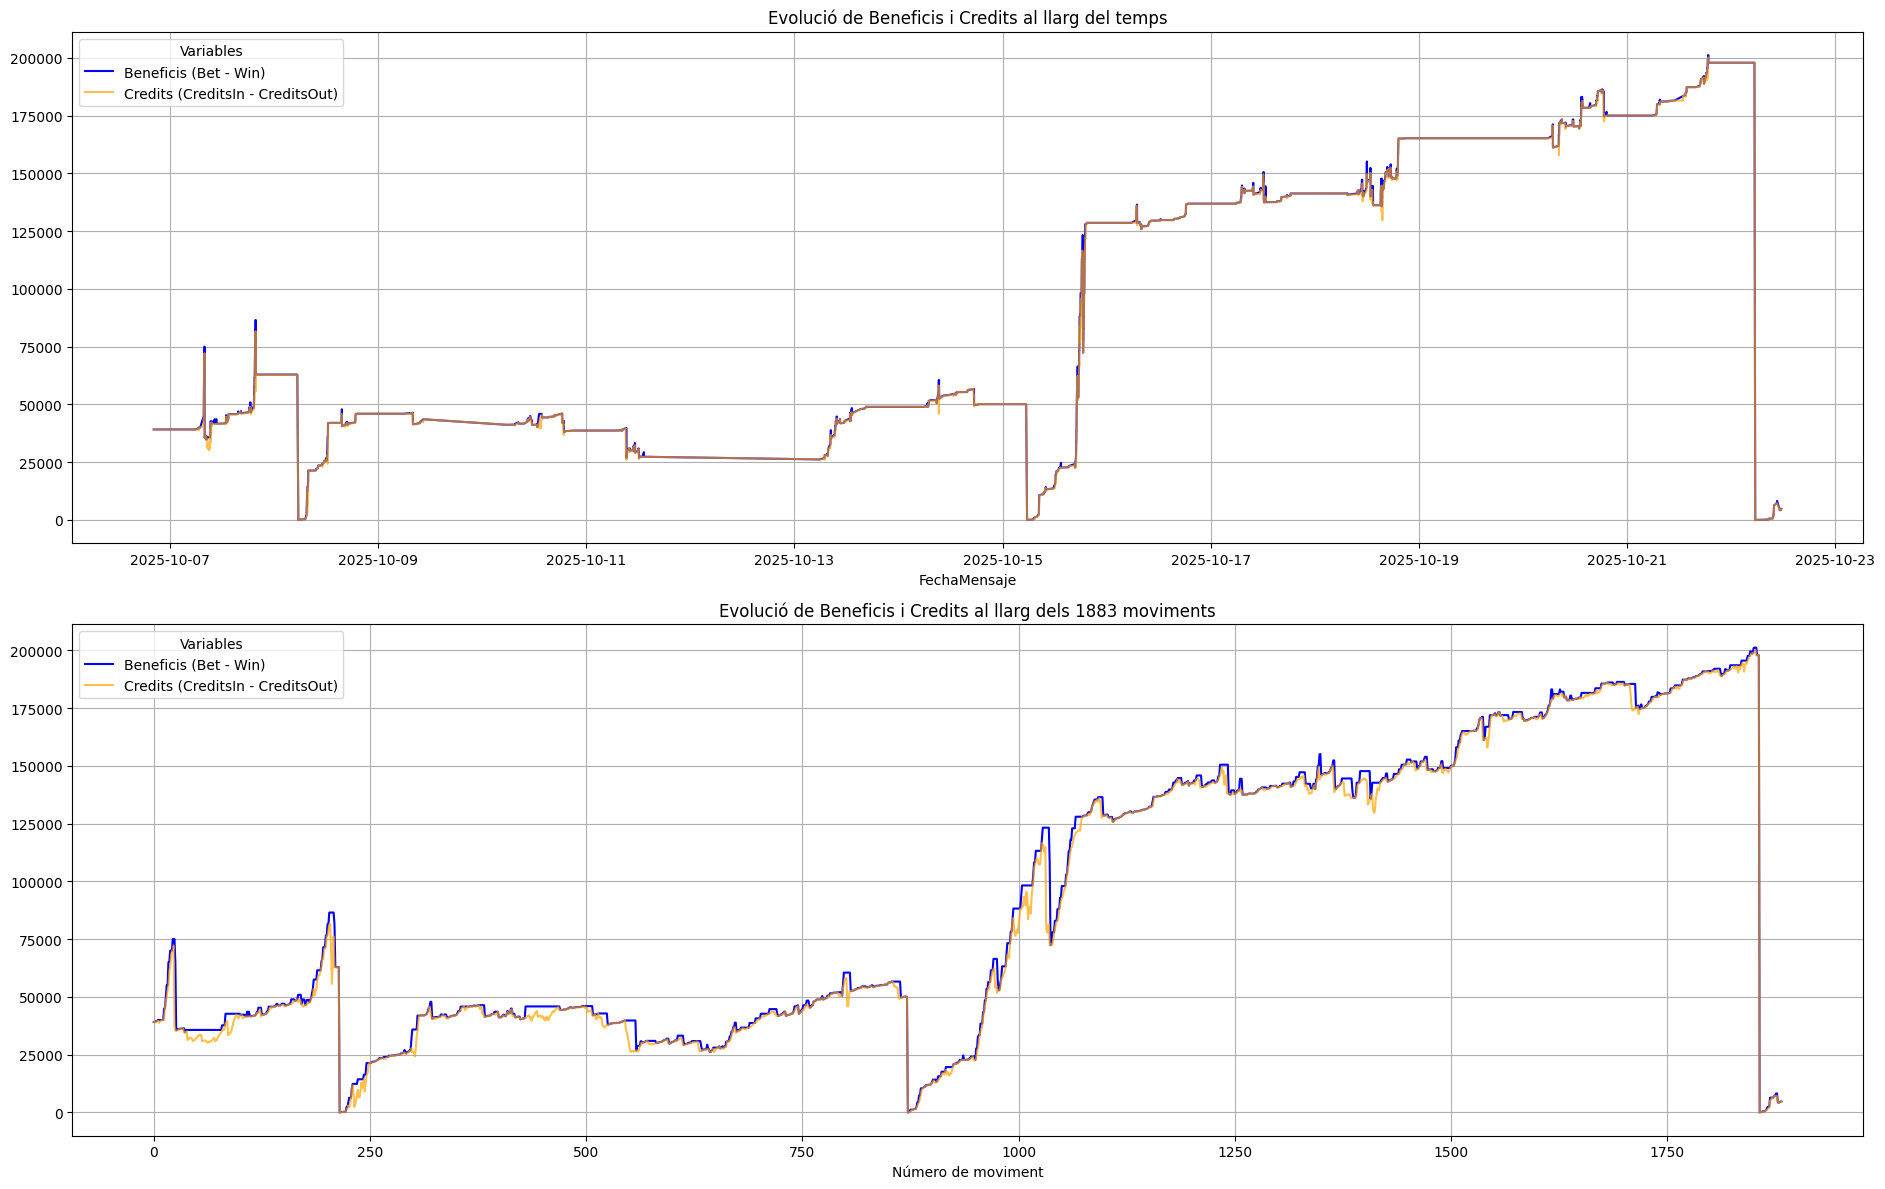


Analitzant màquina: NGO2.18932.24.csv


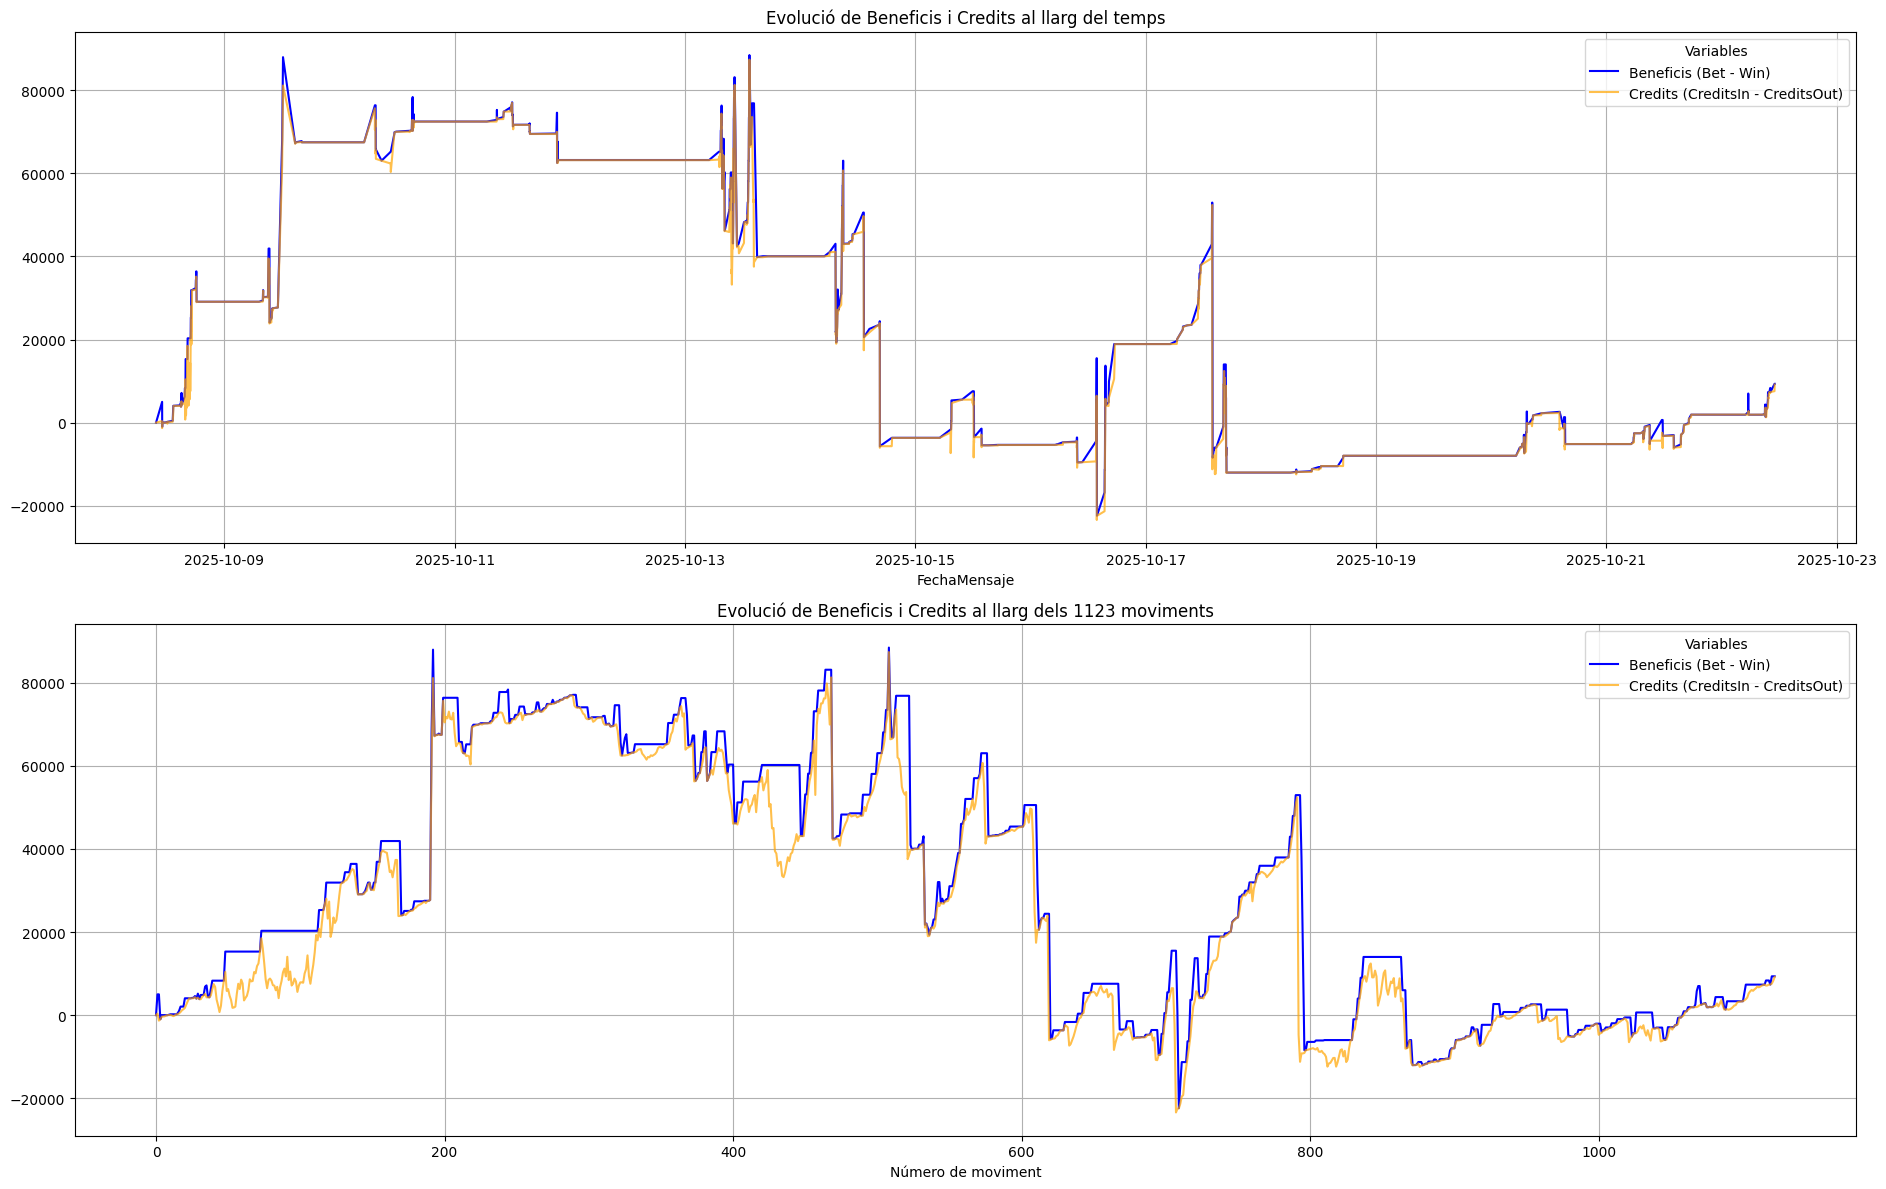


Analitzant màquina: DRS8.4403.20.csv


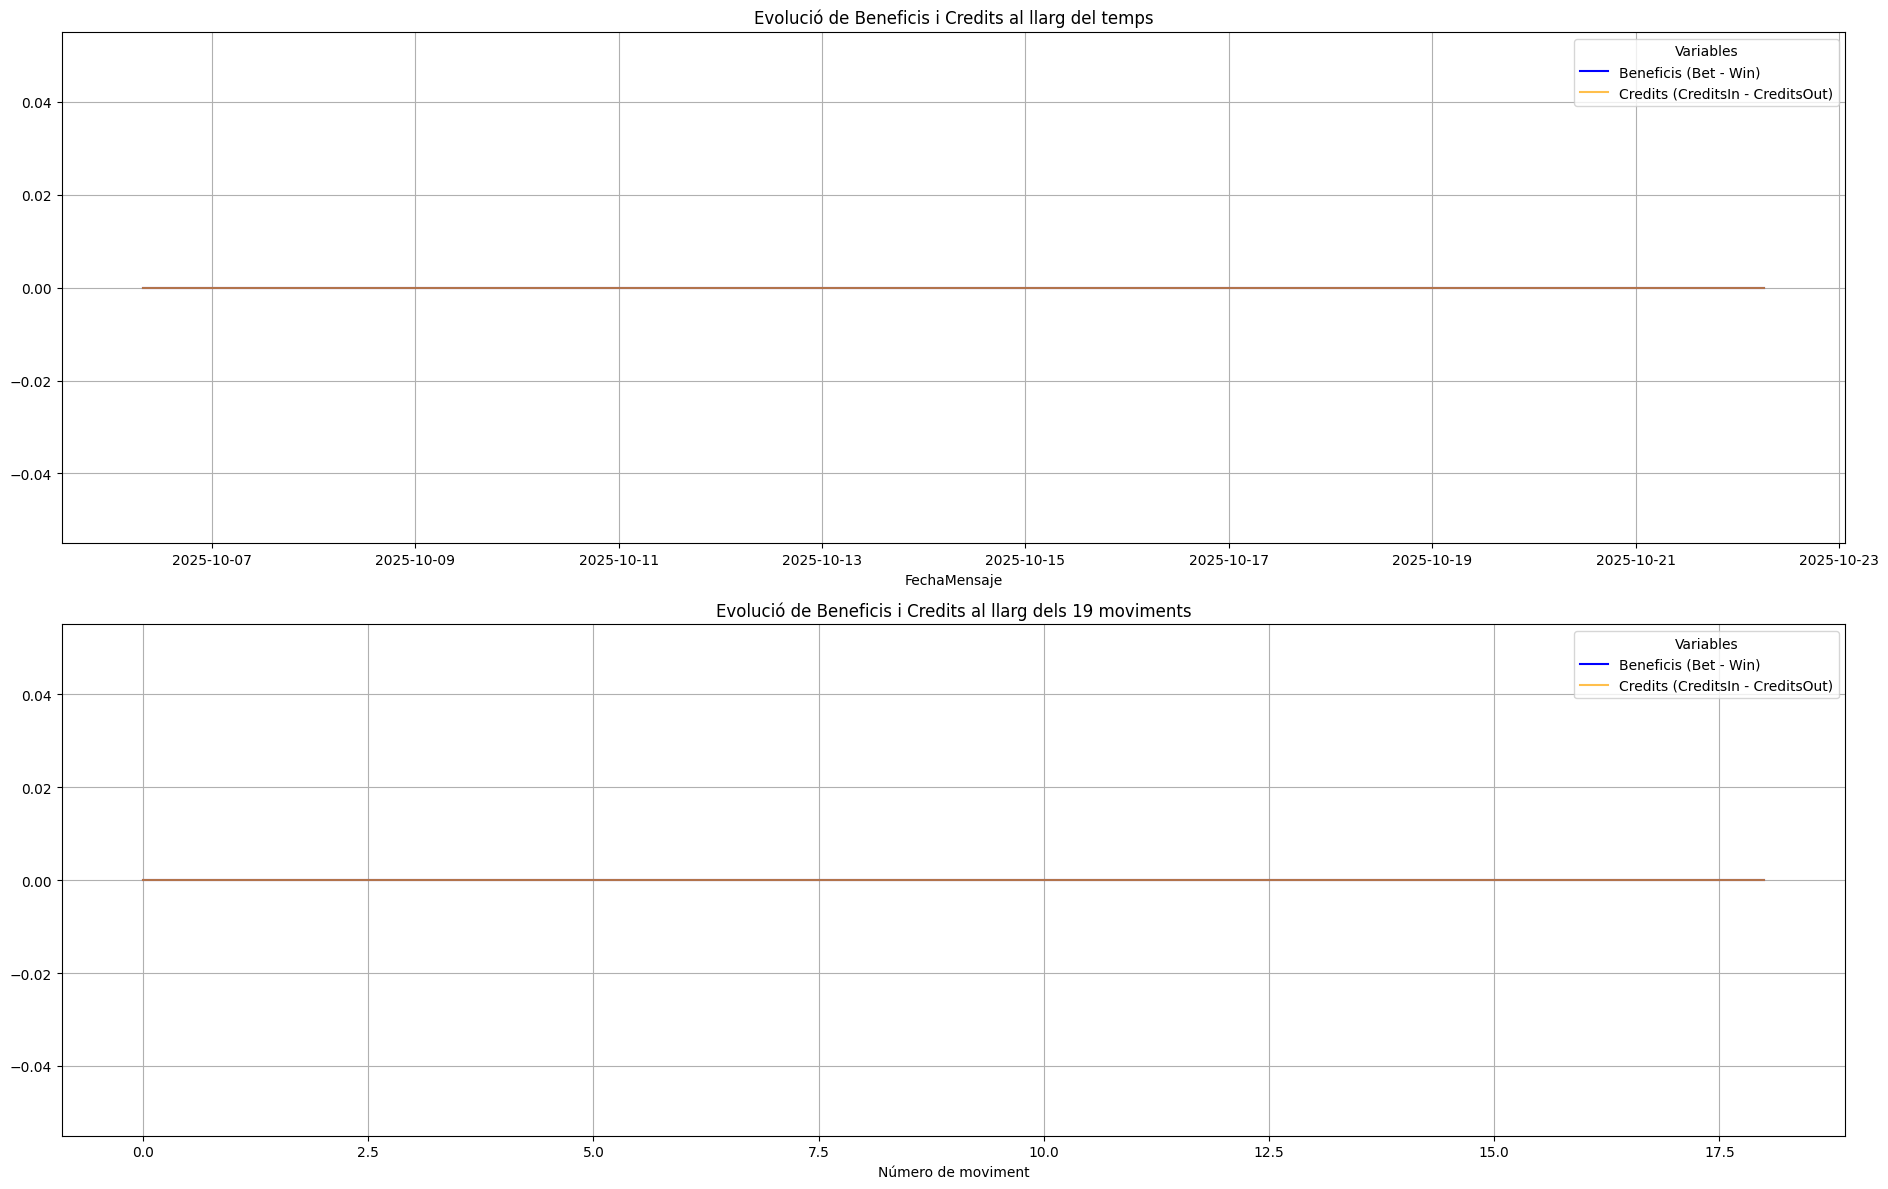


Analitzant màquina: PIG3.59361.20.csv


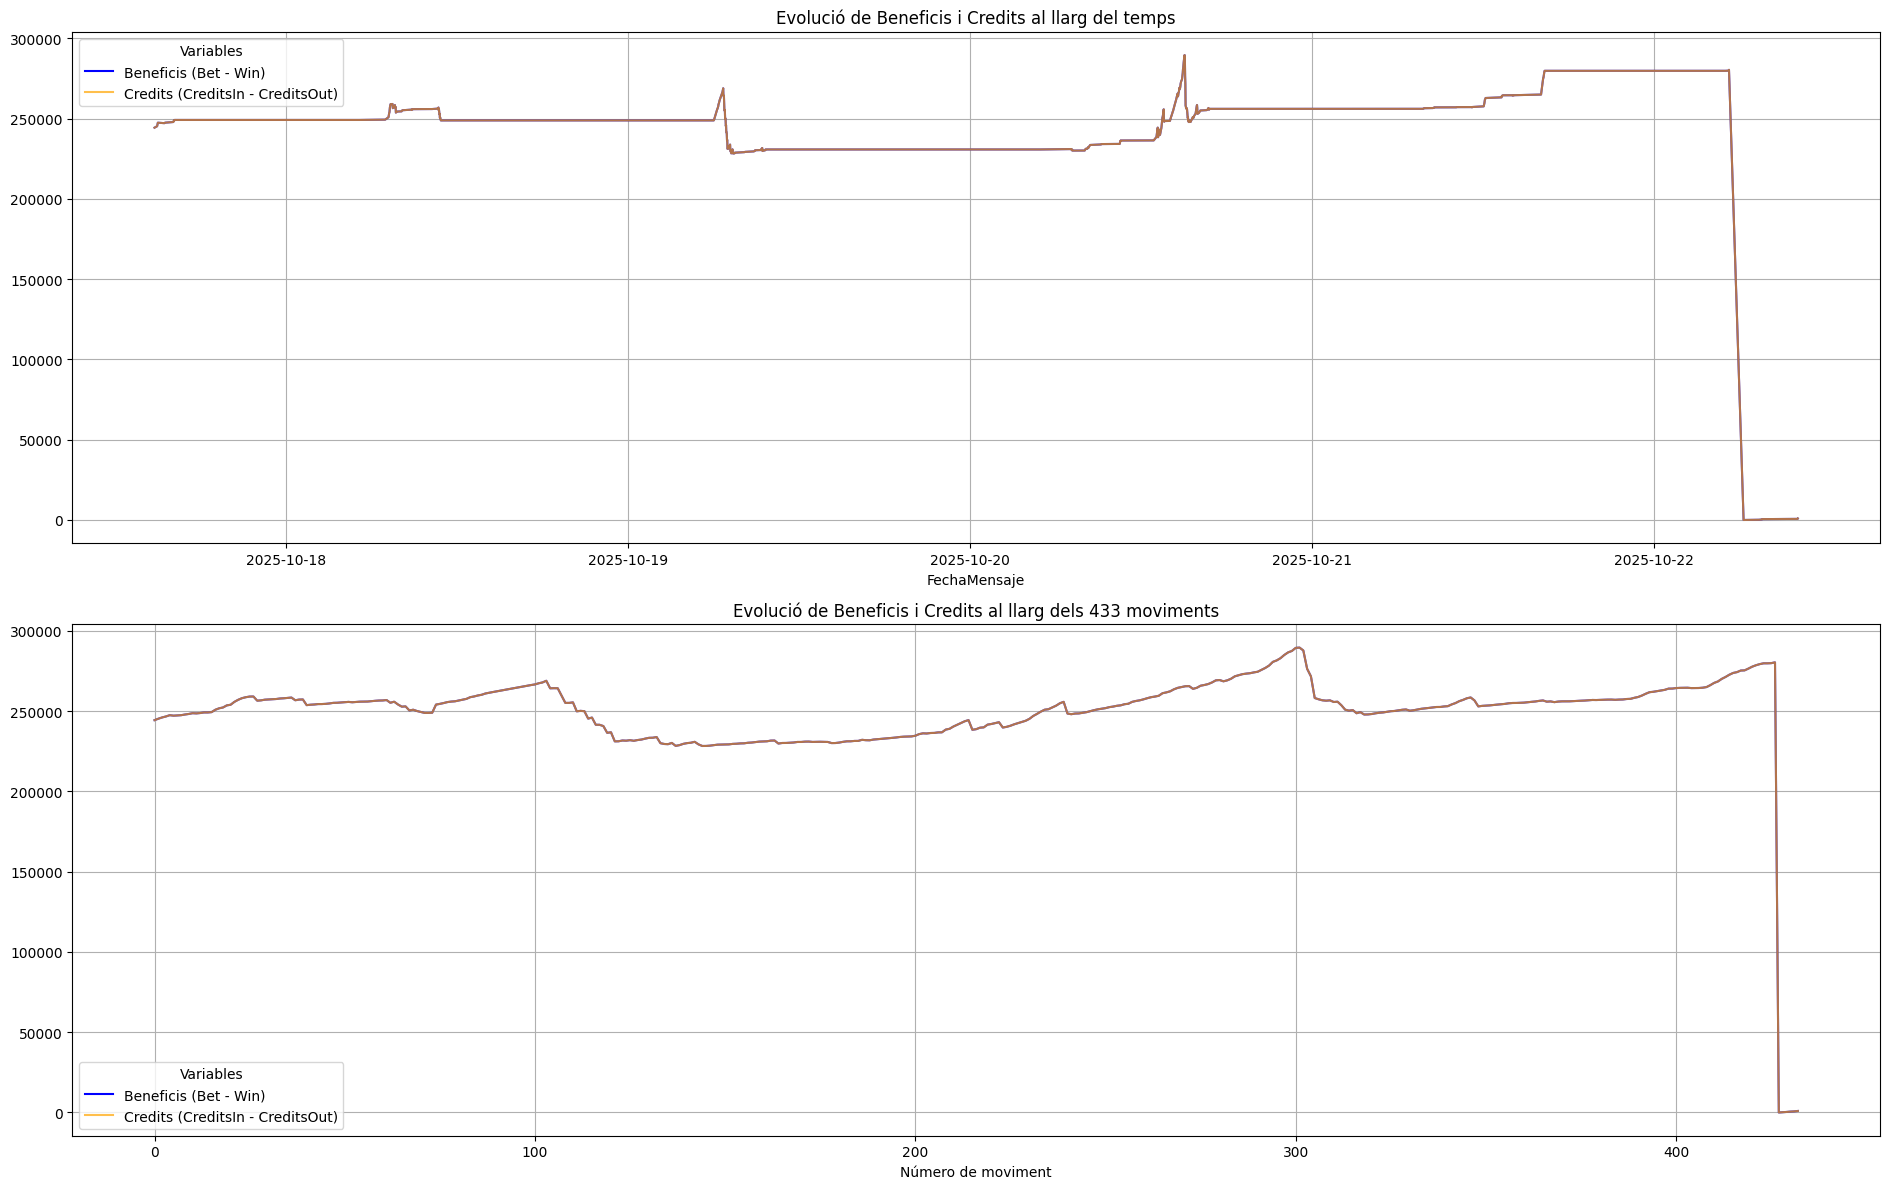


Analitzant màquina: HIT2.334.24.csv


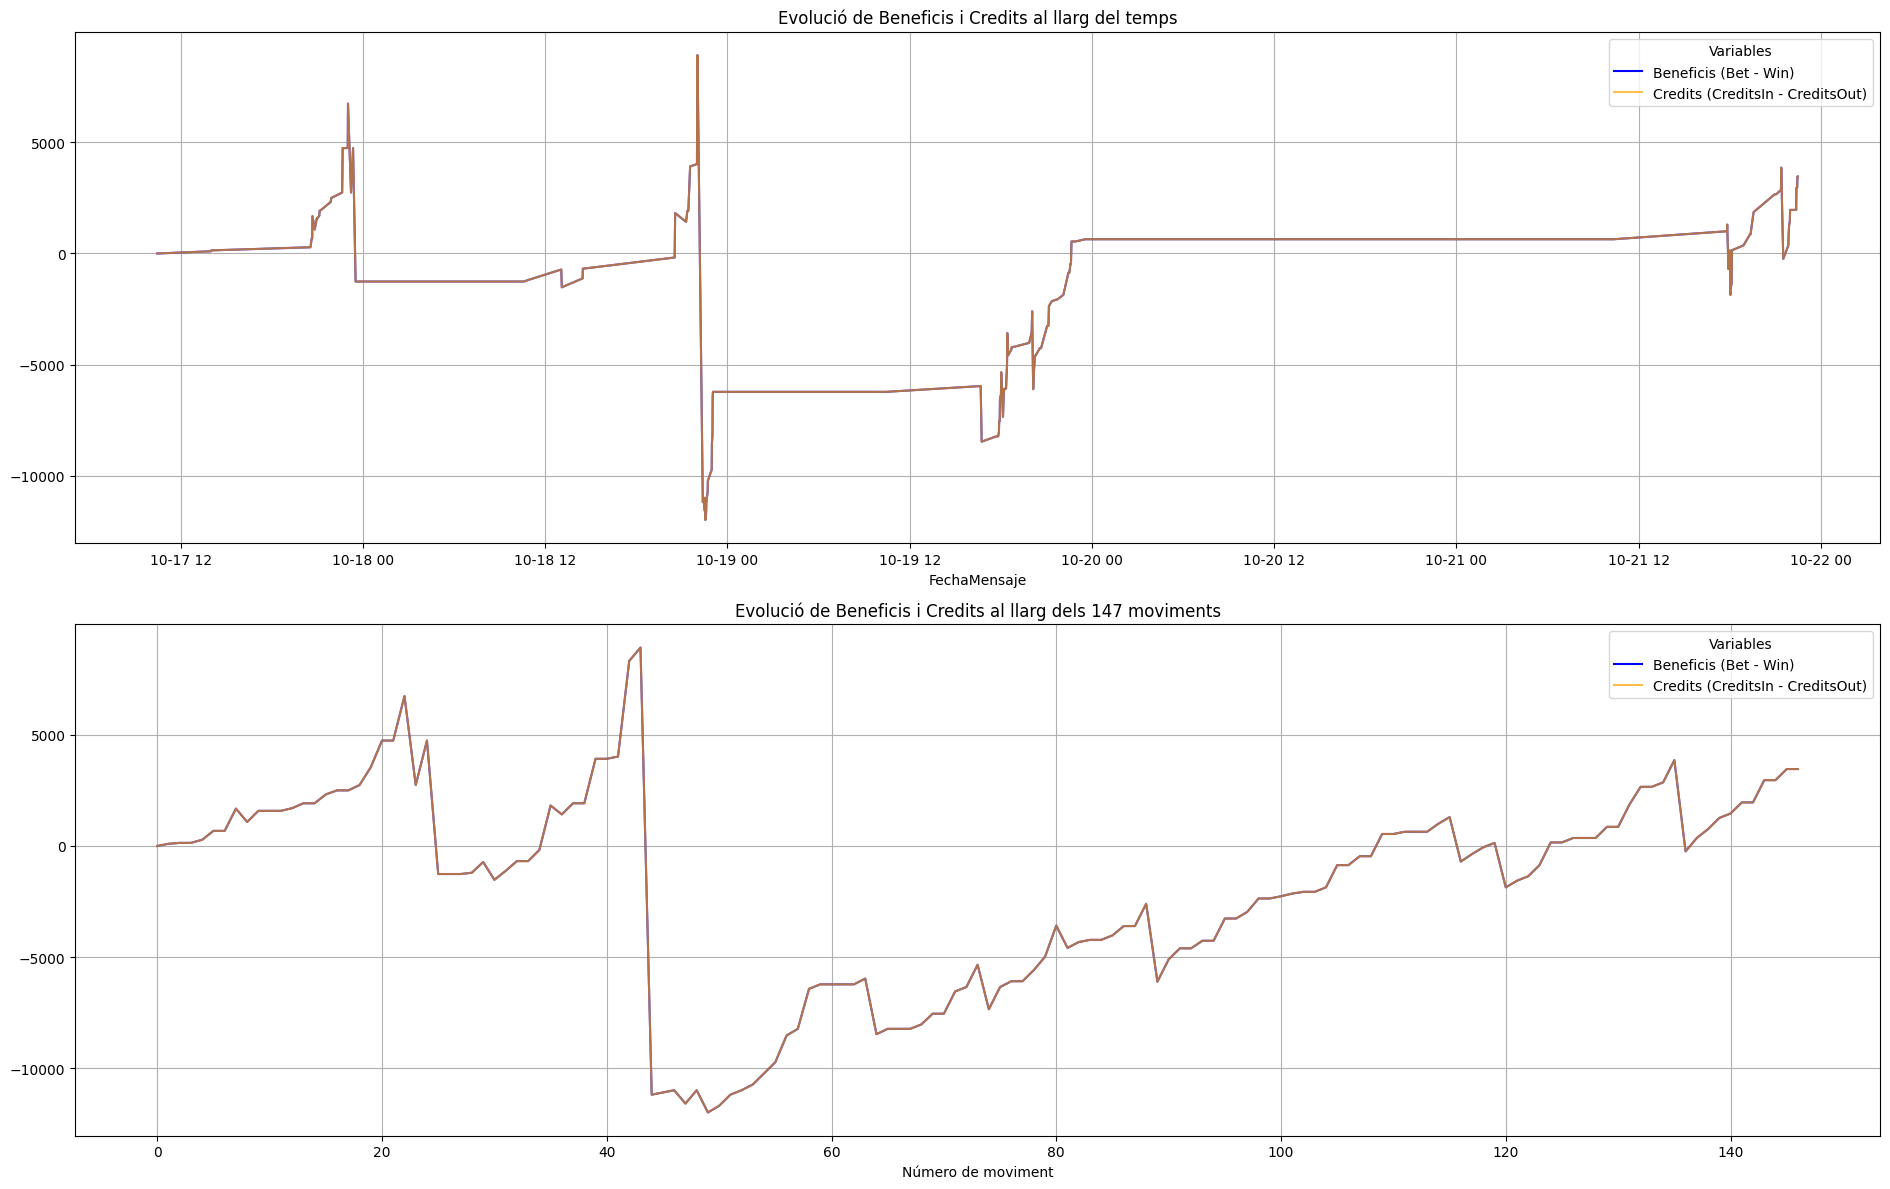


Analitzant màquina: MAX3.444.21.csv


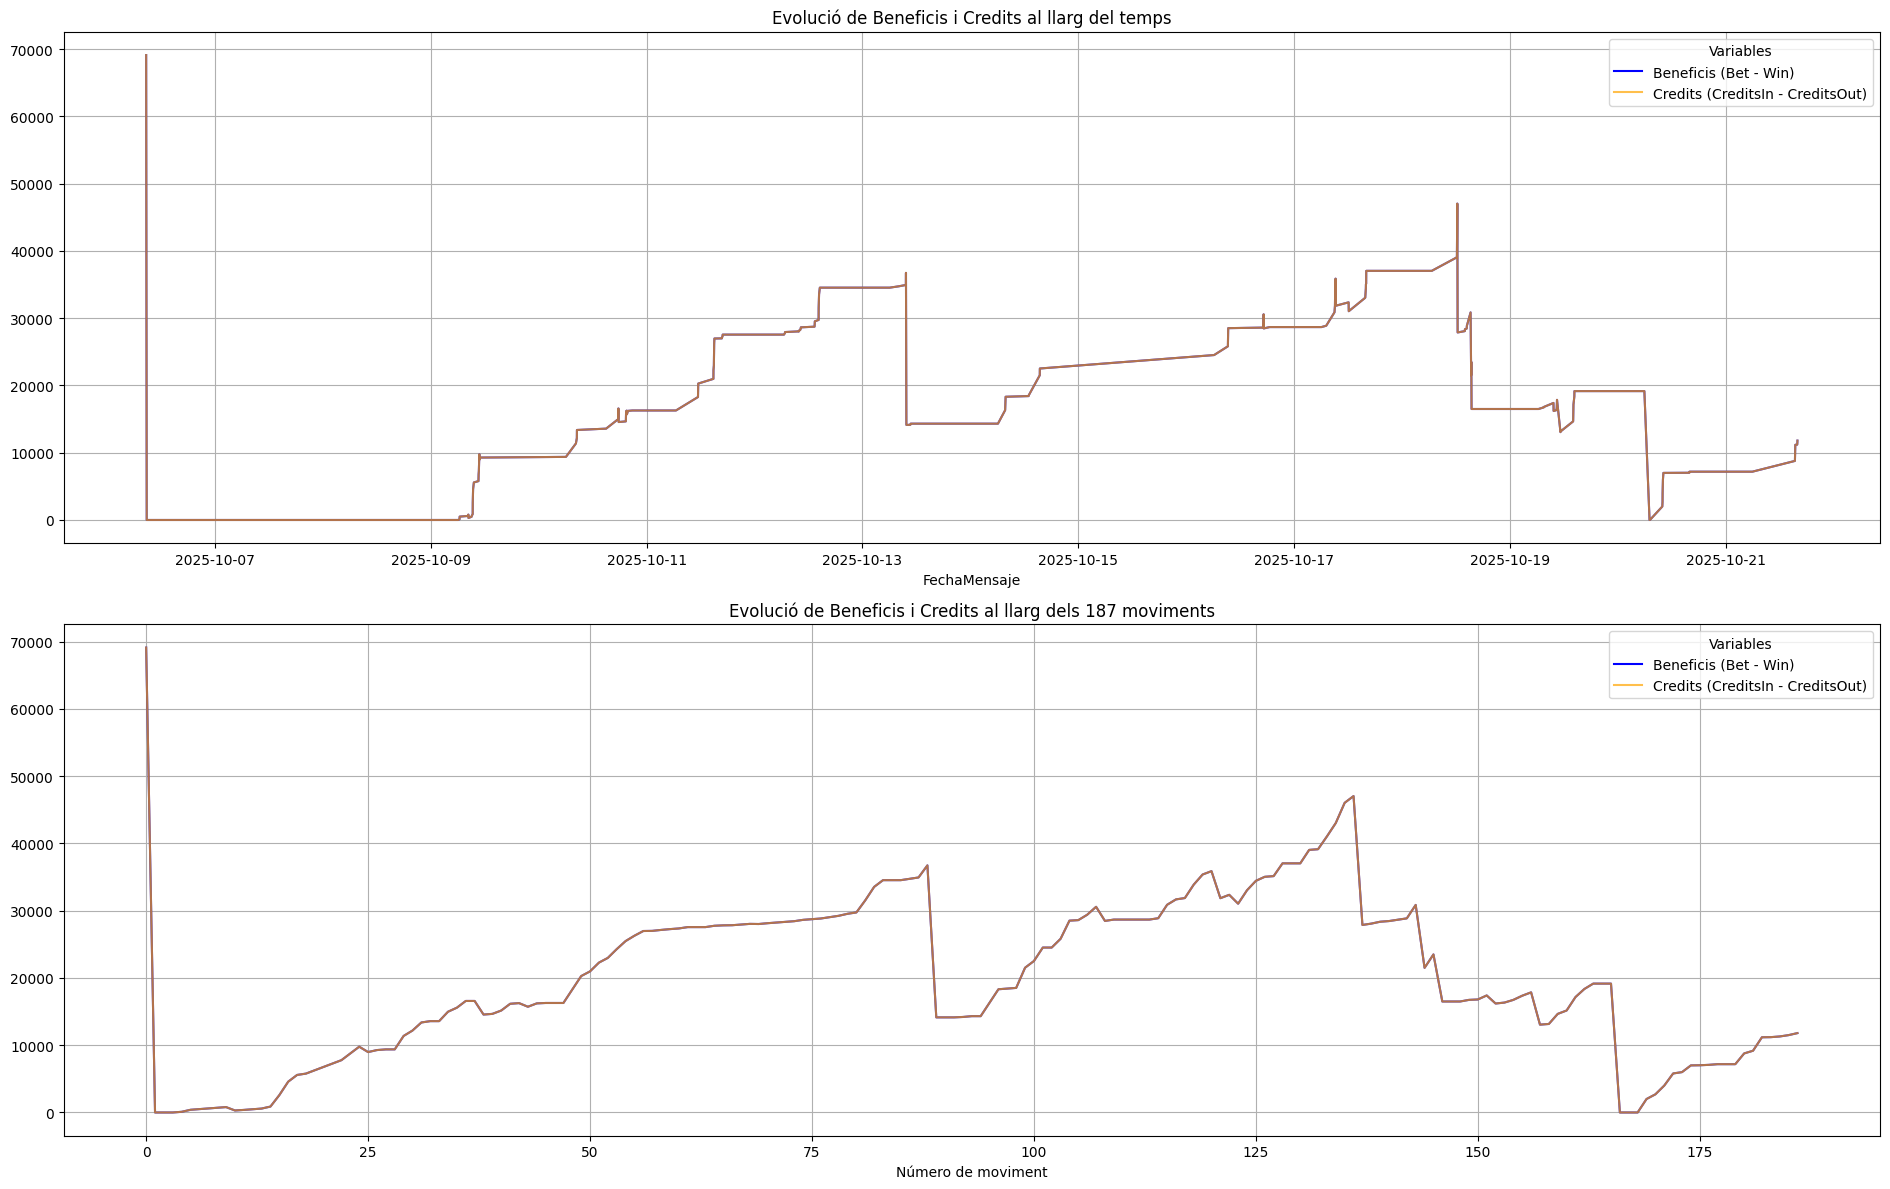


Analitzant màquina: BWG2.138.24.csv


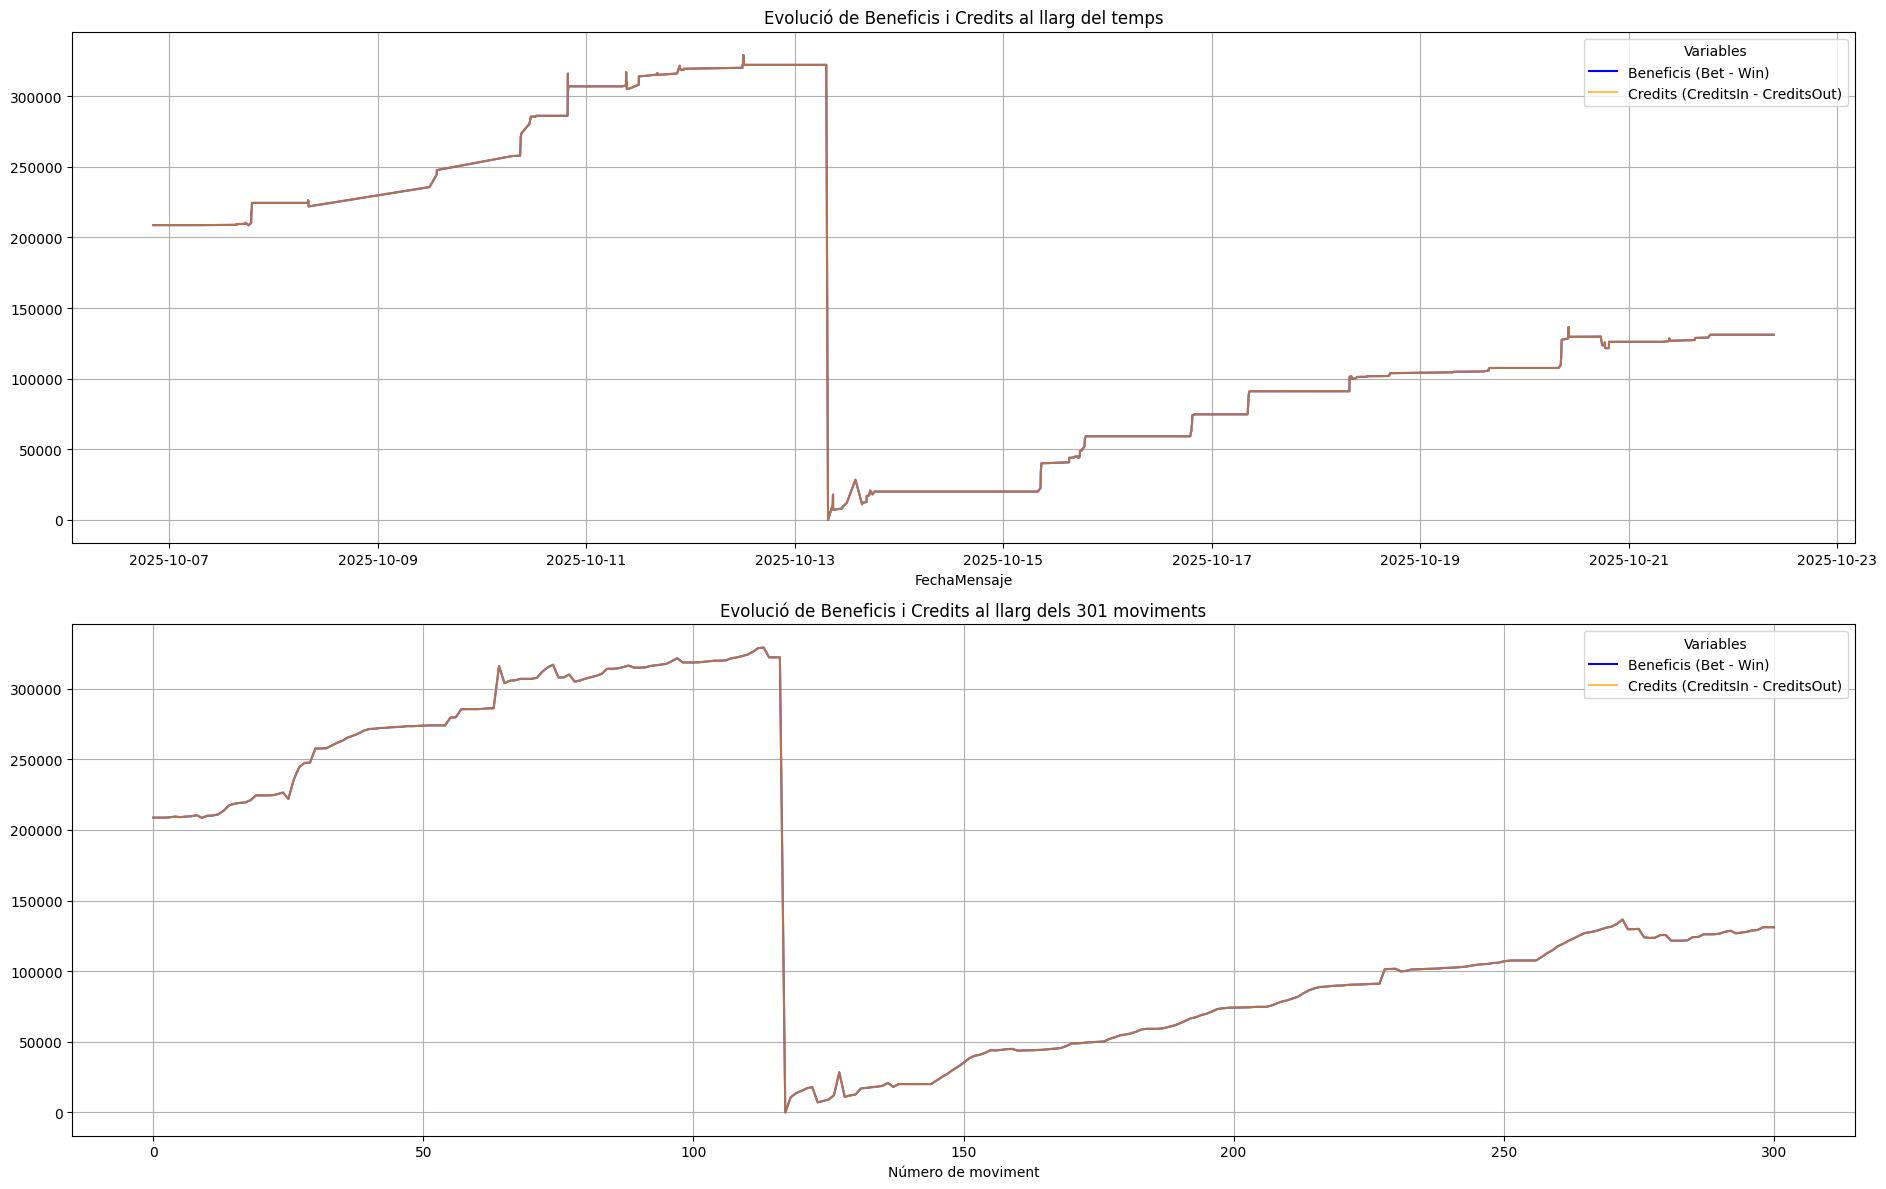


Analitzant màquina: MIR2.555.25.csv


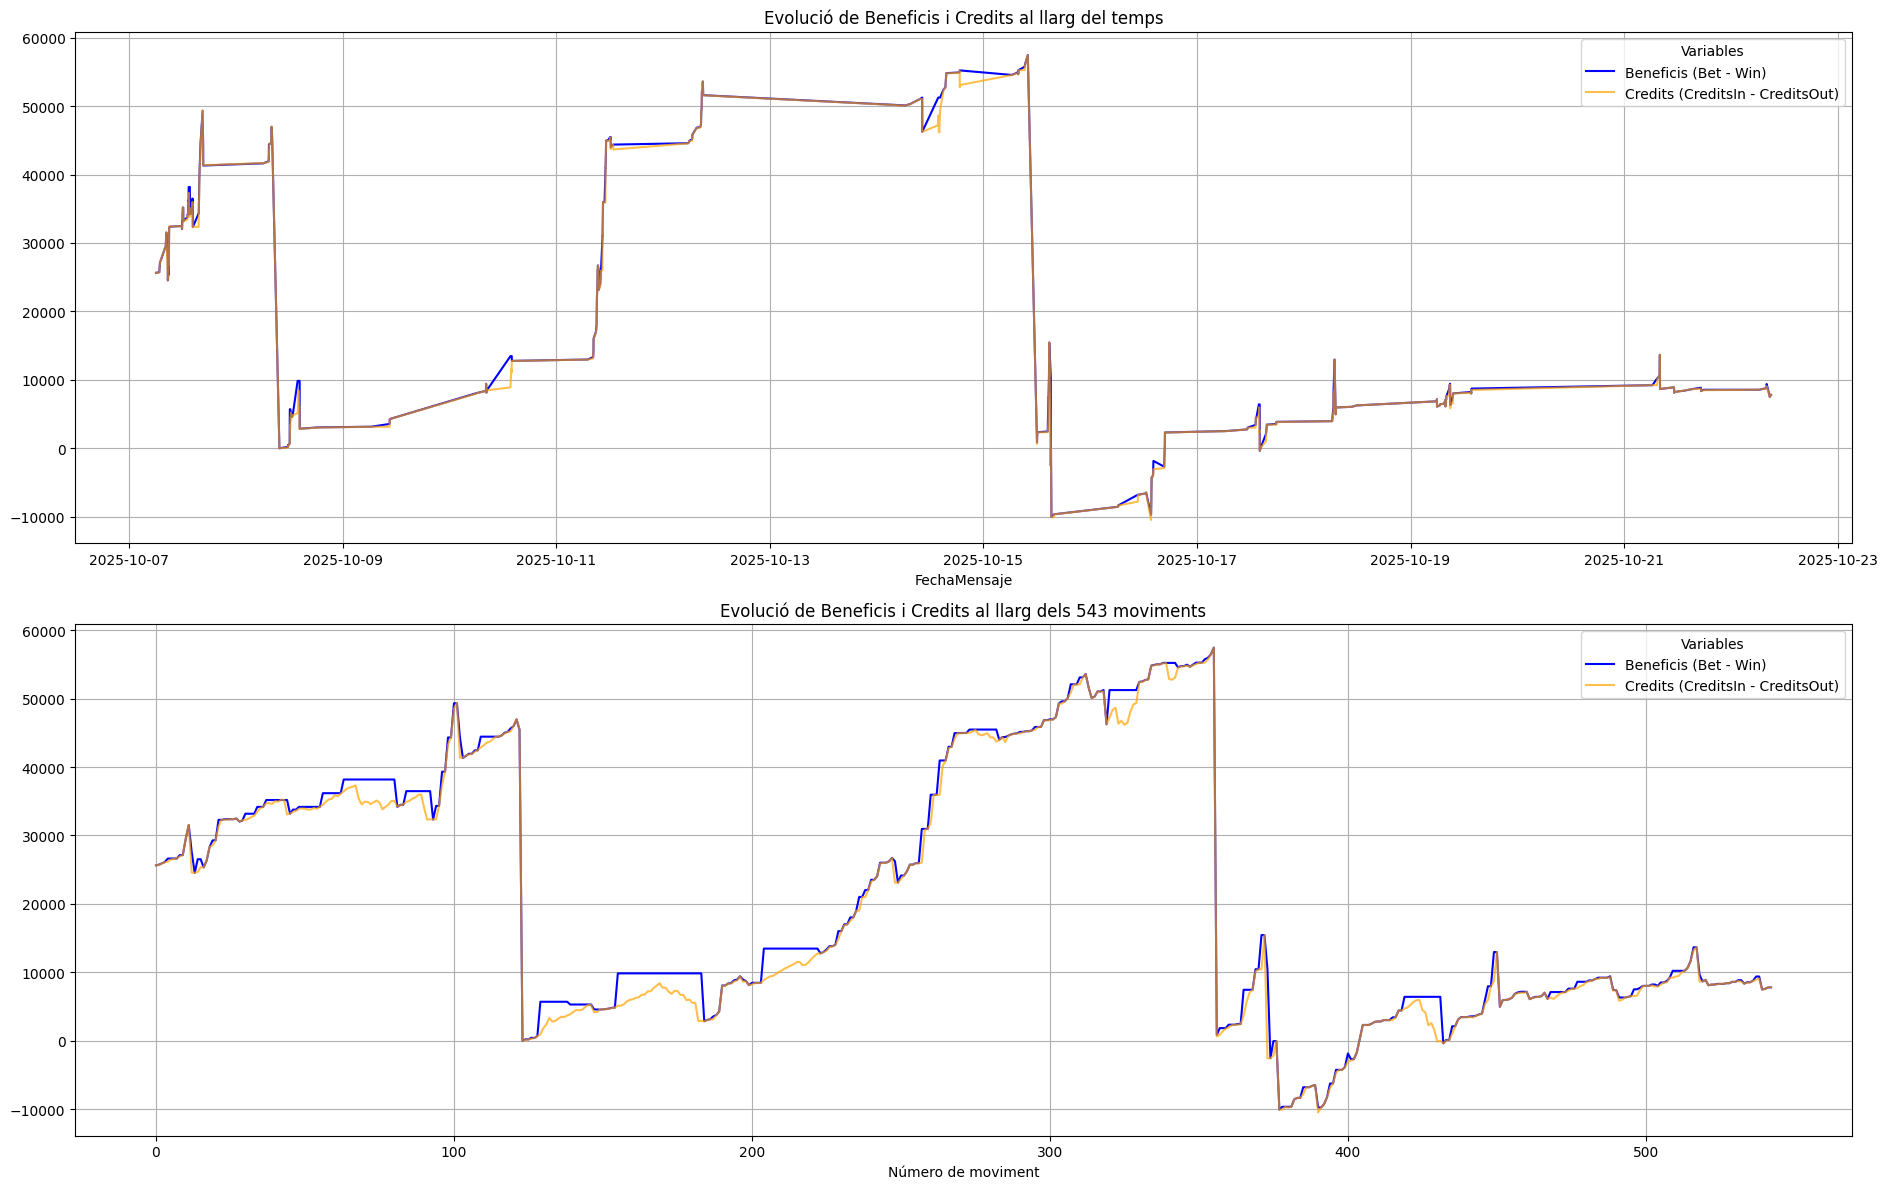


Analitzant màquina: NLX2.11648.24.csv


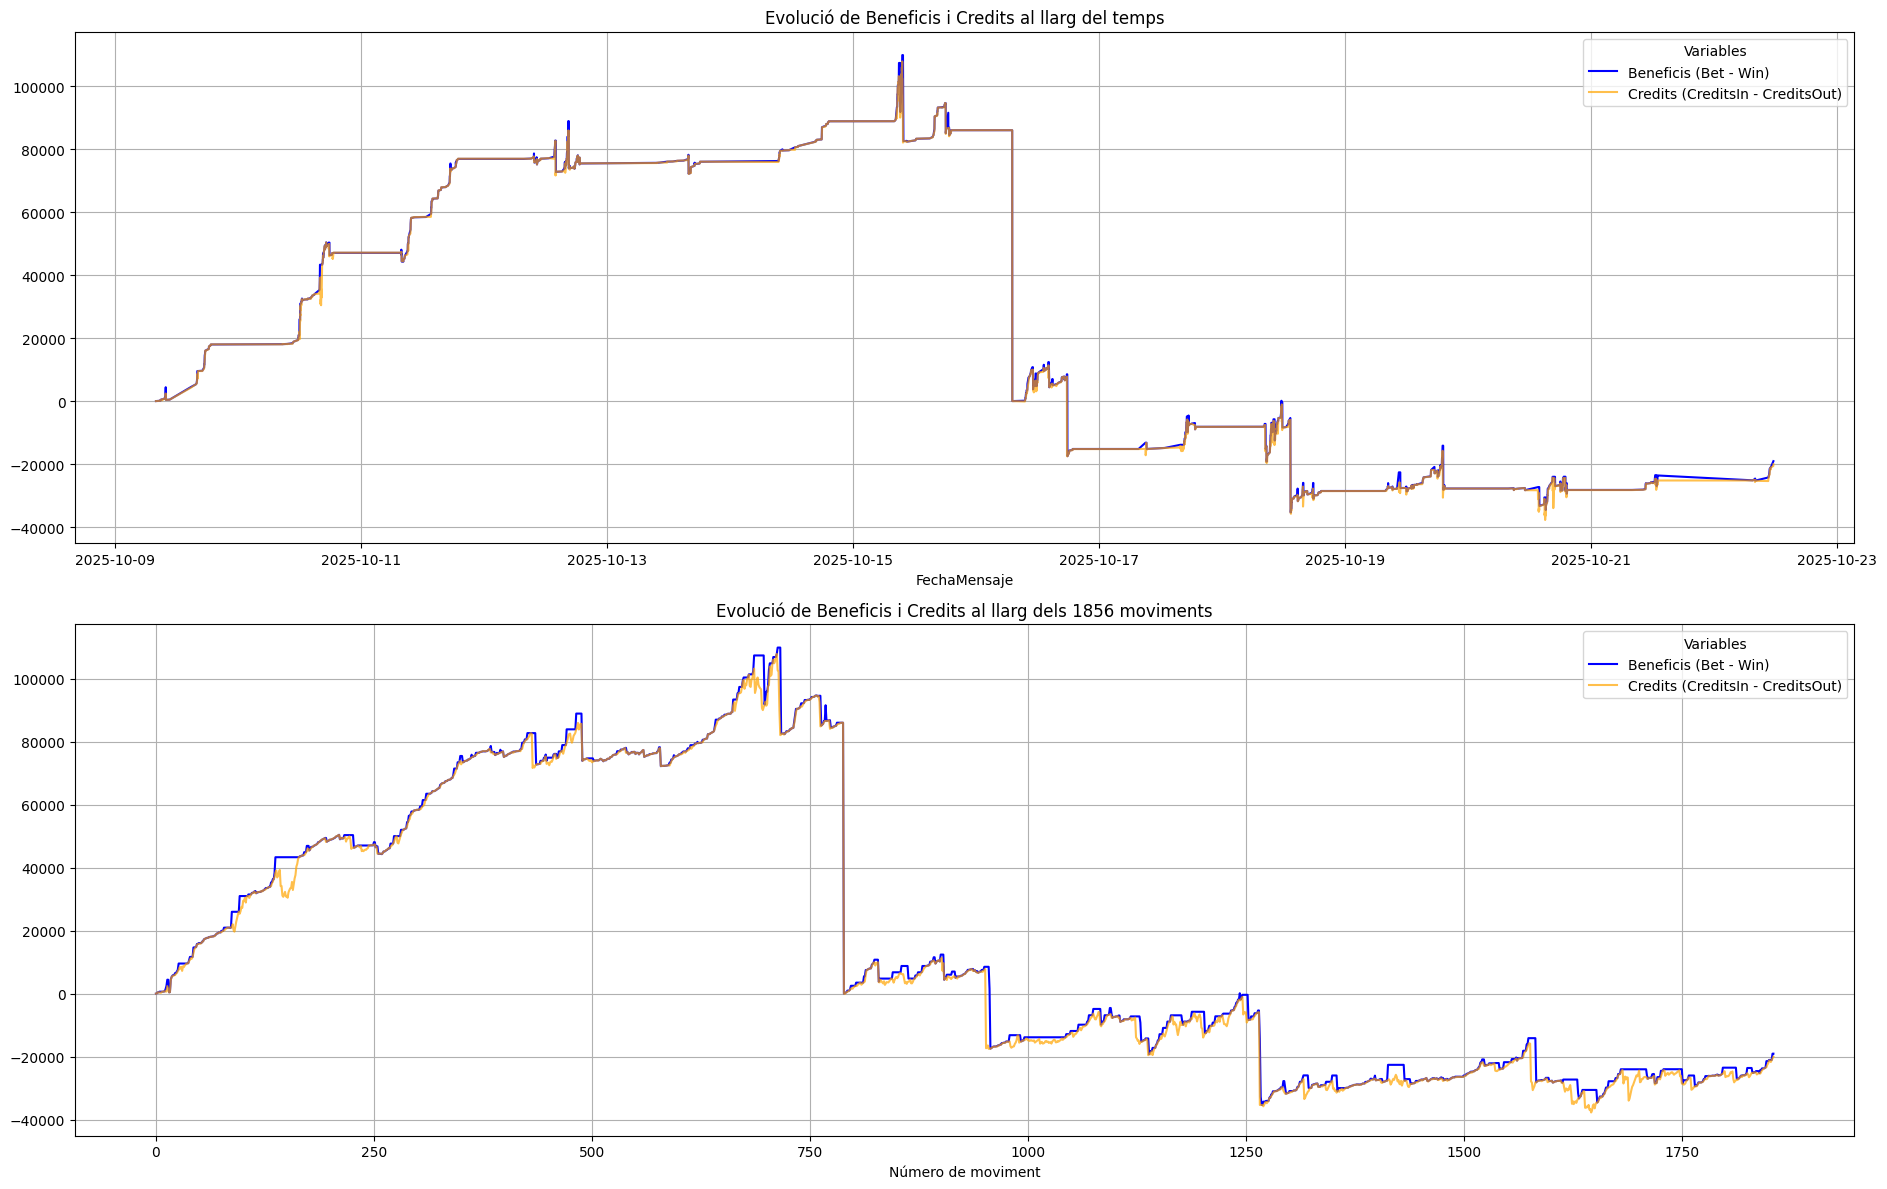


Analitzant màquina: NGO3.16903.24.csv


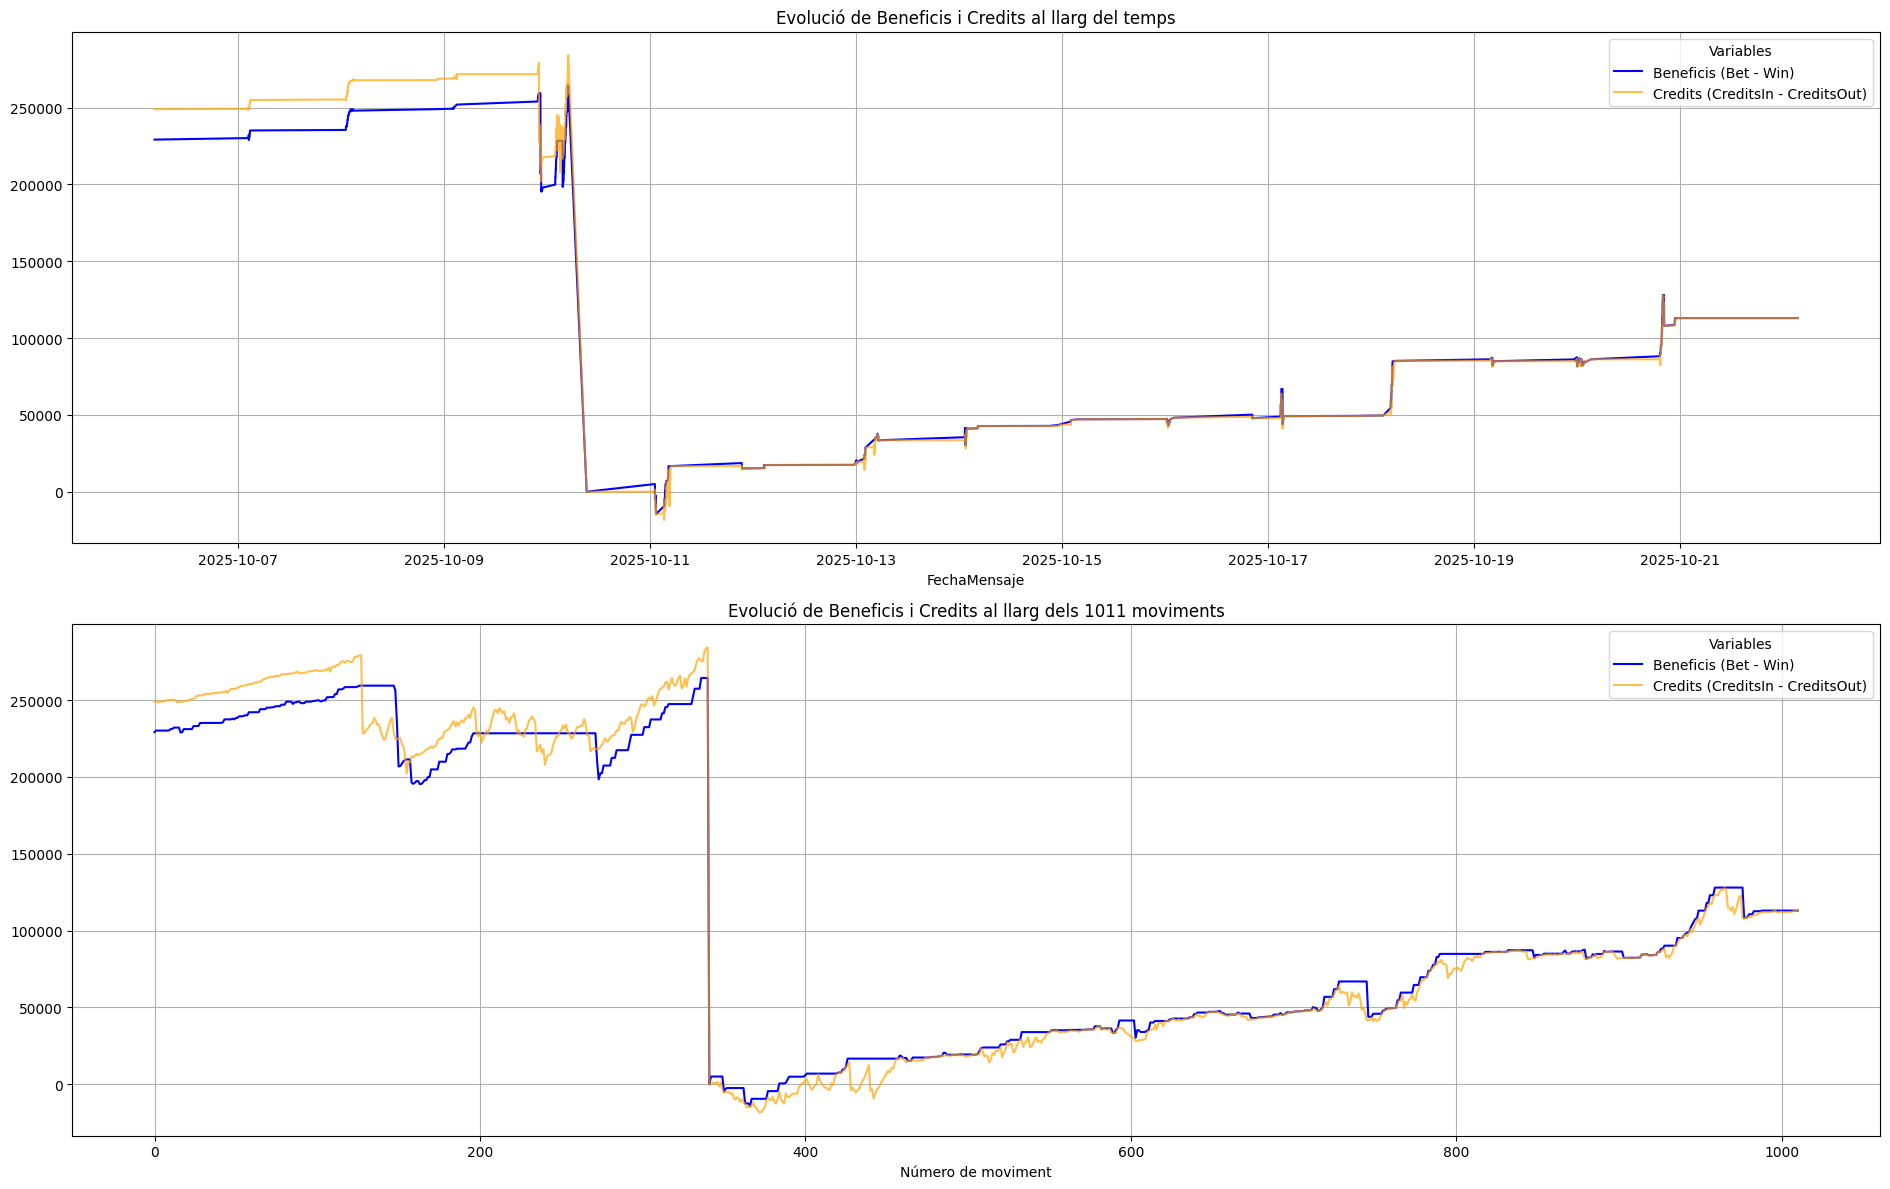


Analitzant màquina: NLS2.21768.24.csv


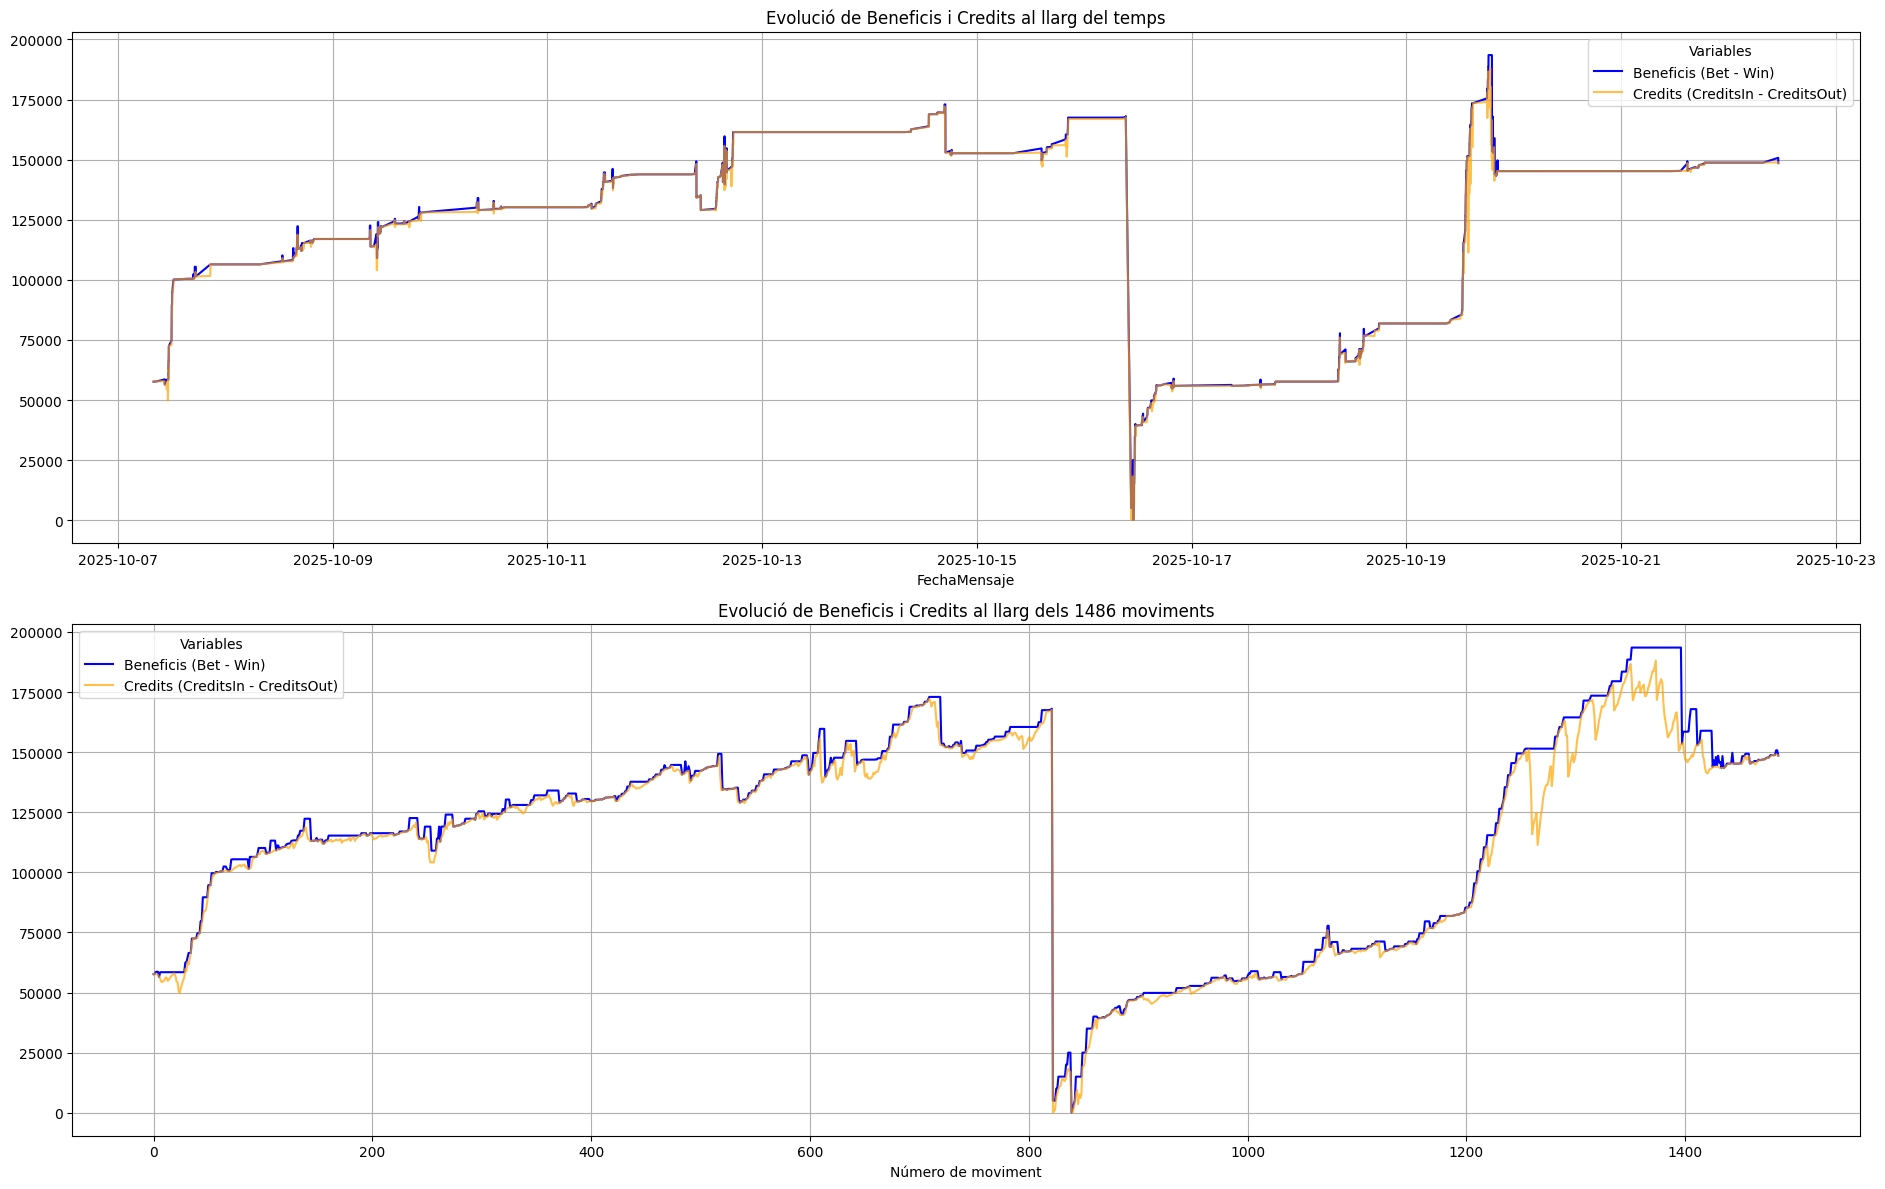


Analitzant màquina: FLO2.3592.16.csv


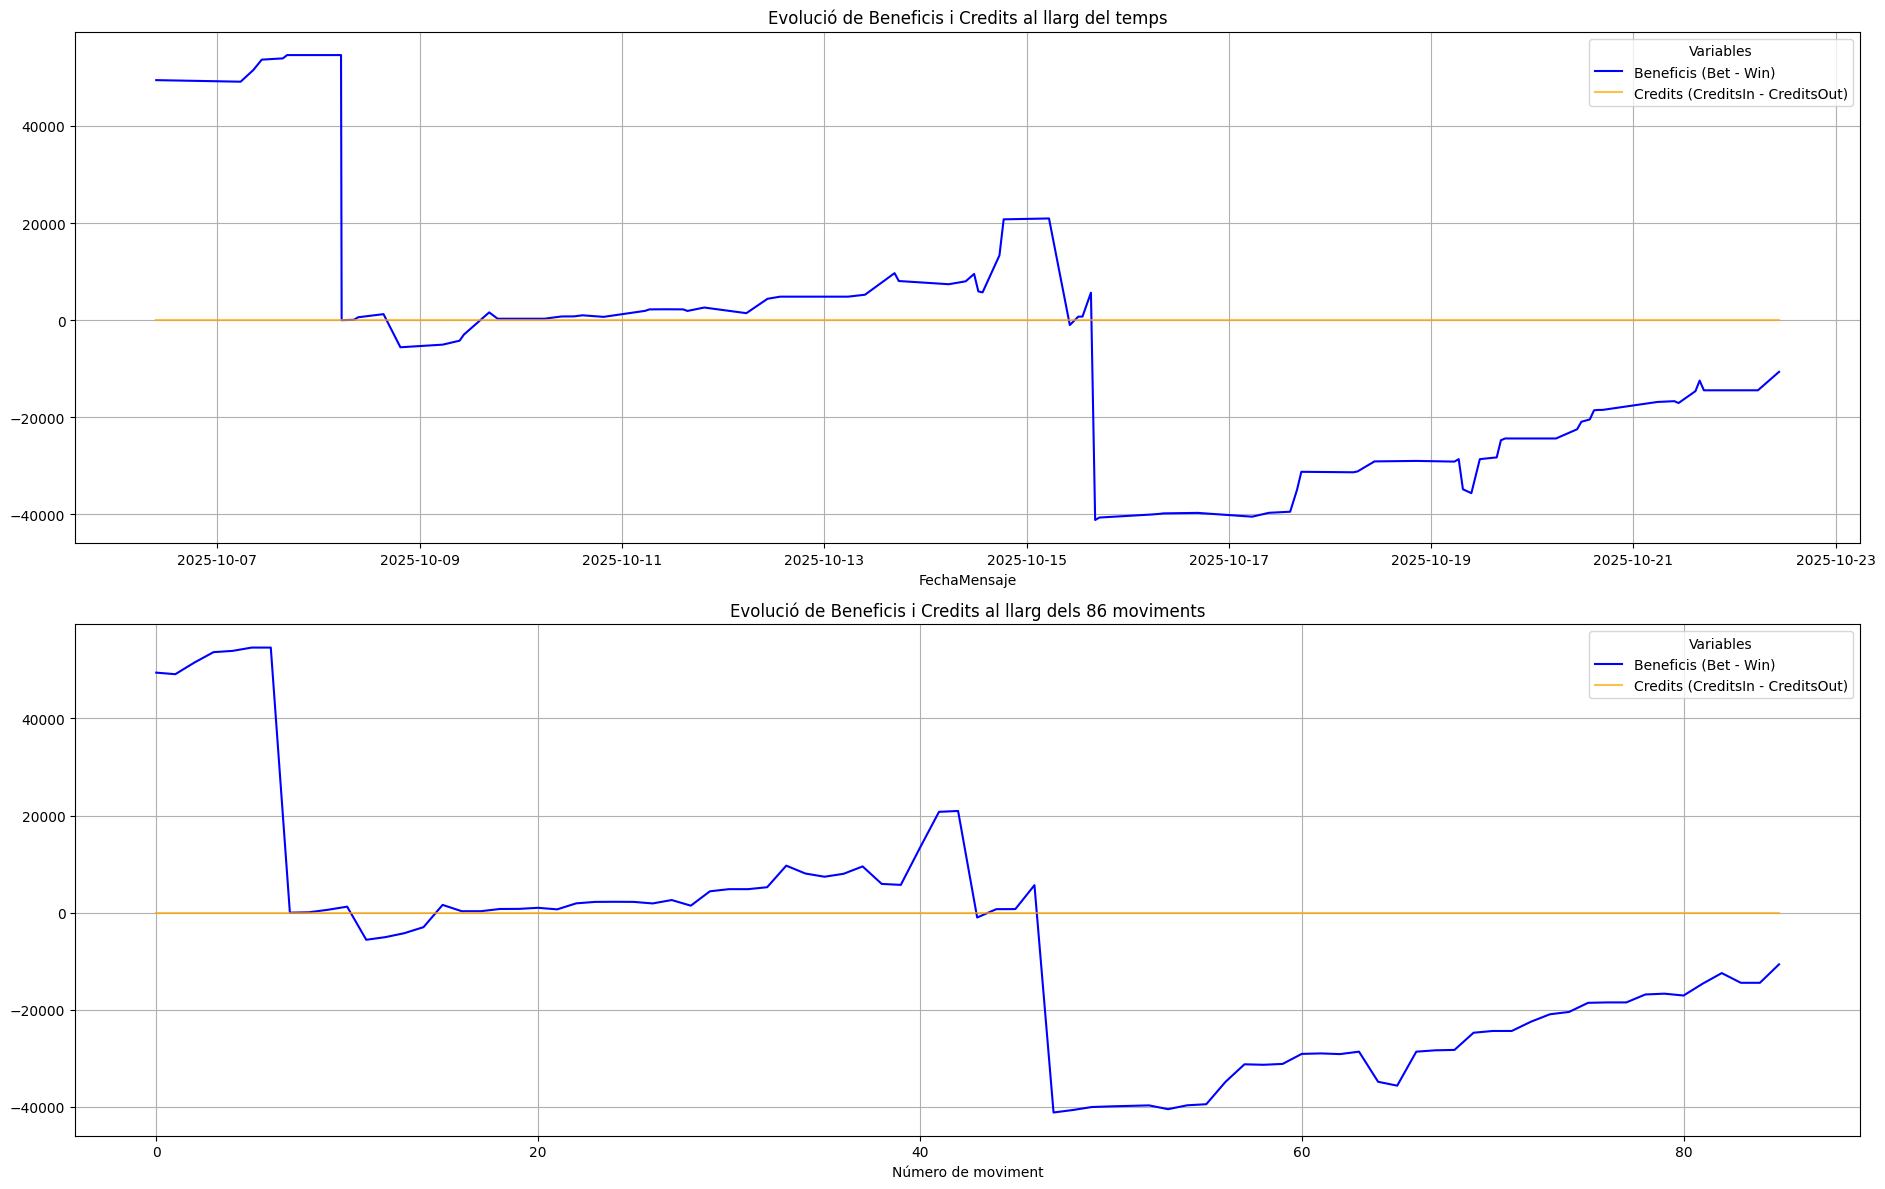


Analitzant màquina: NLR2.8728.23.csv


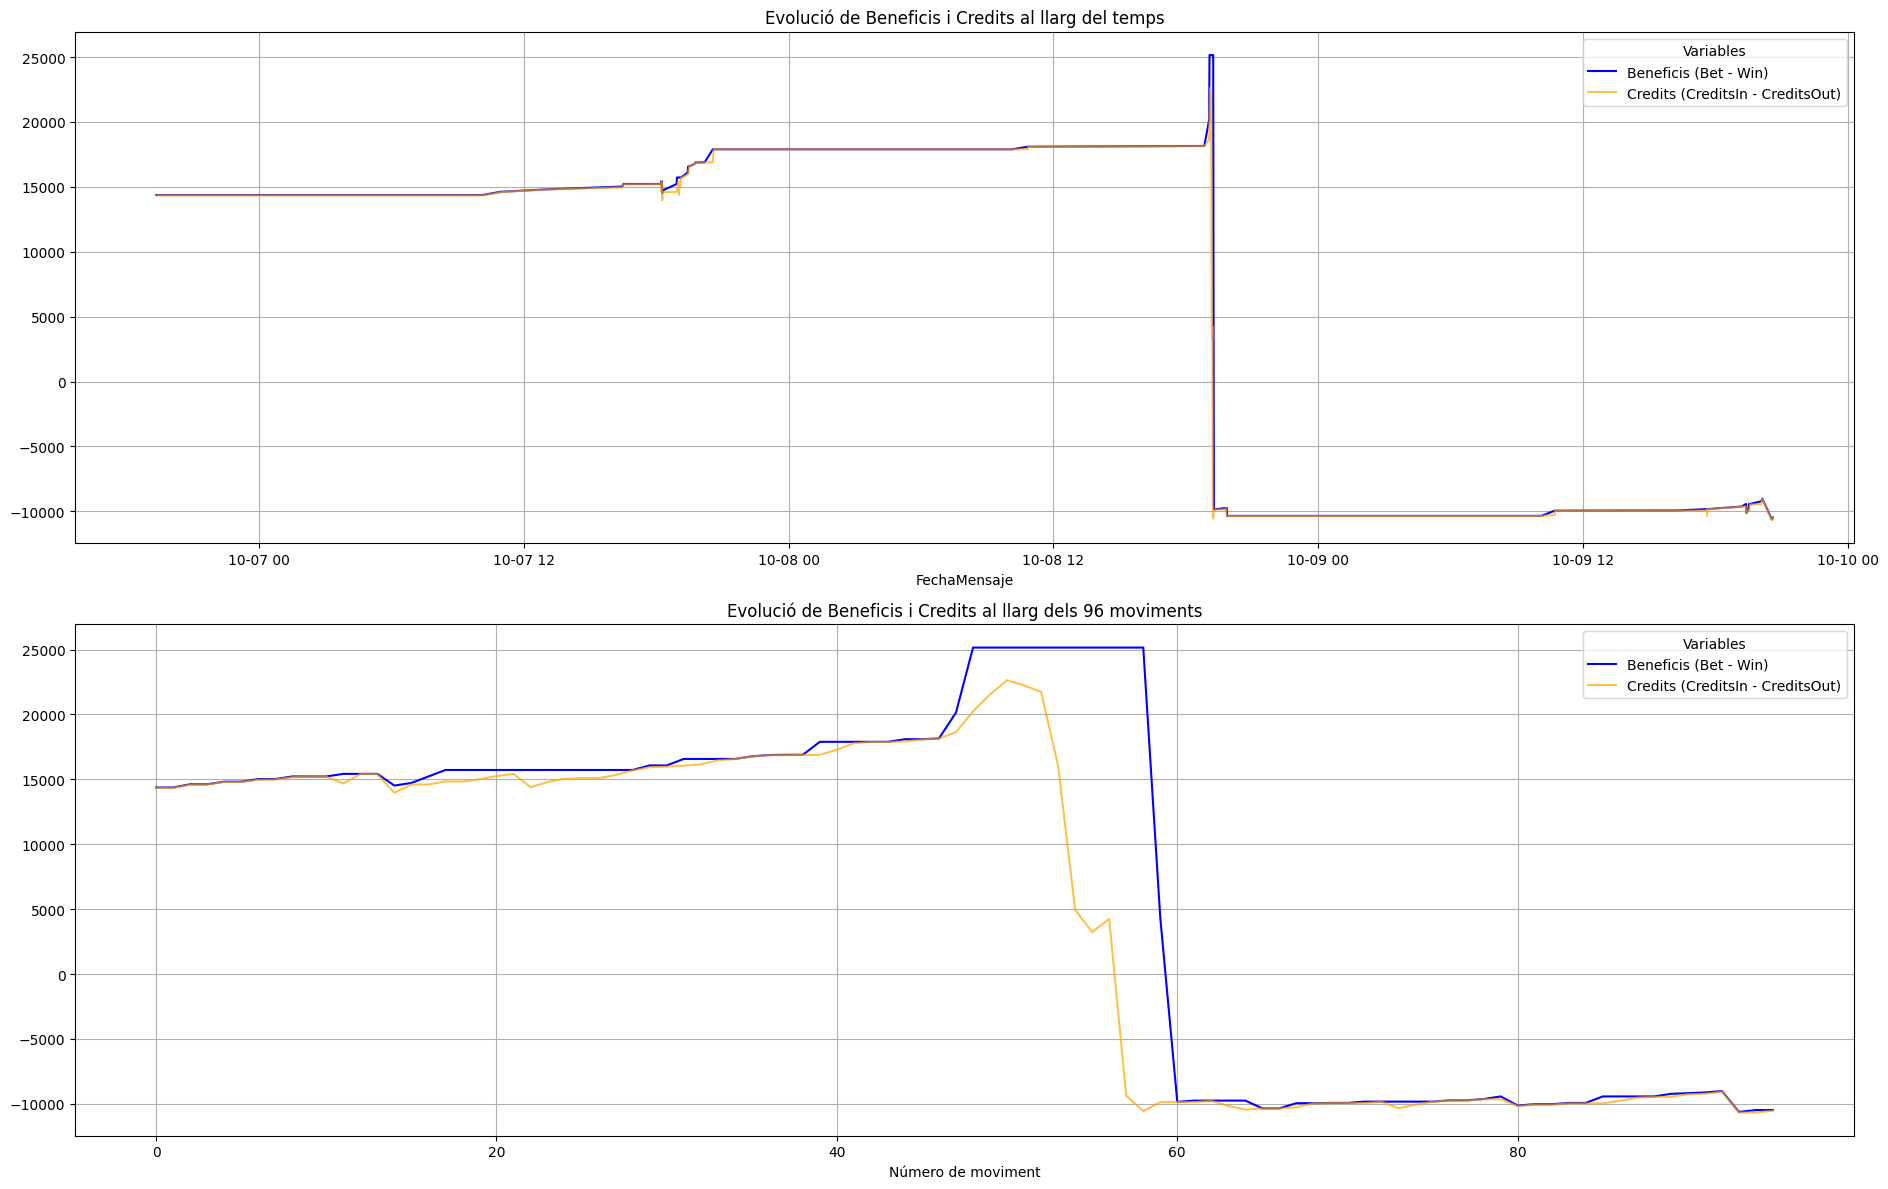


Analitzant màquina: NGO2.17459.24.csv


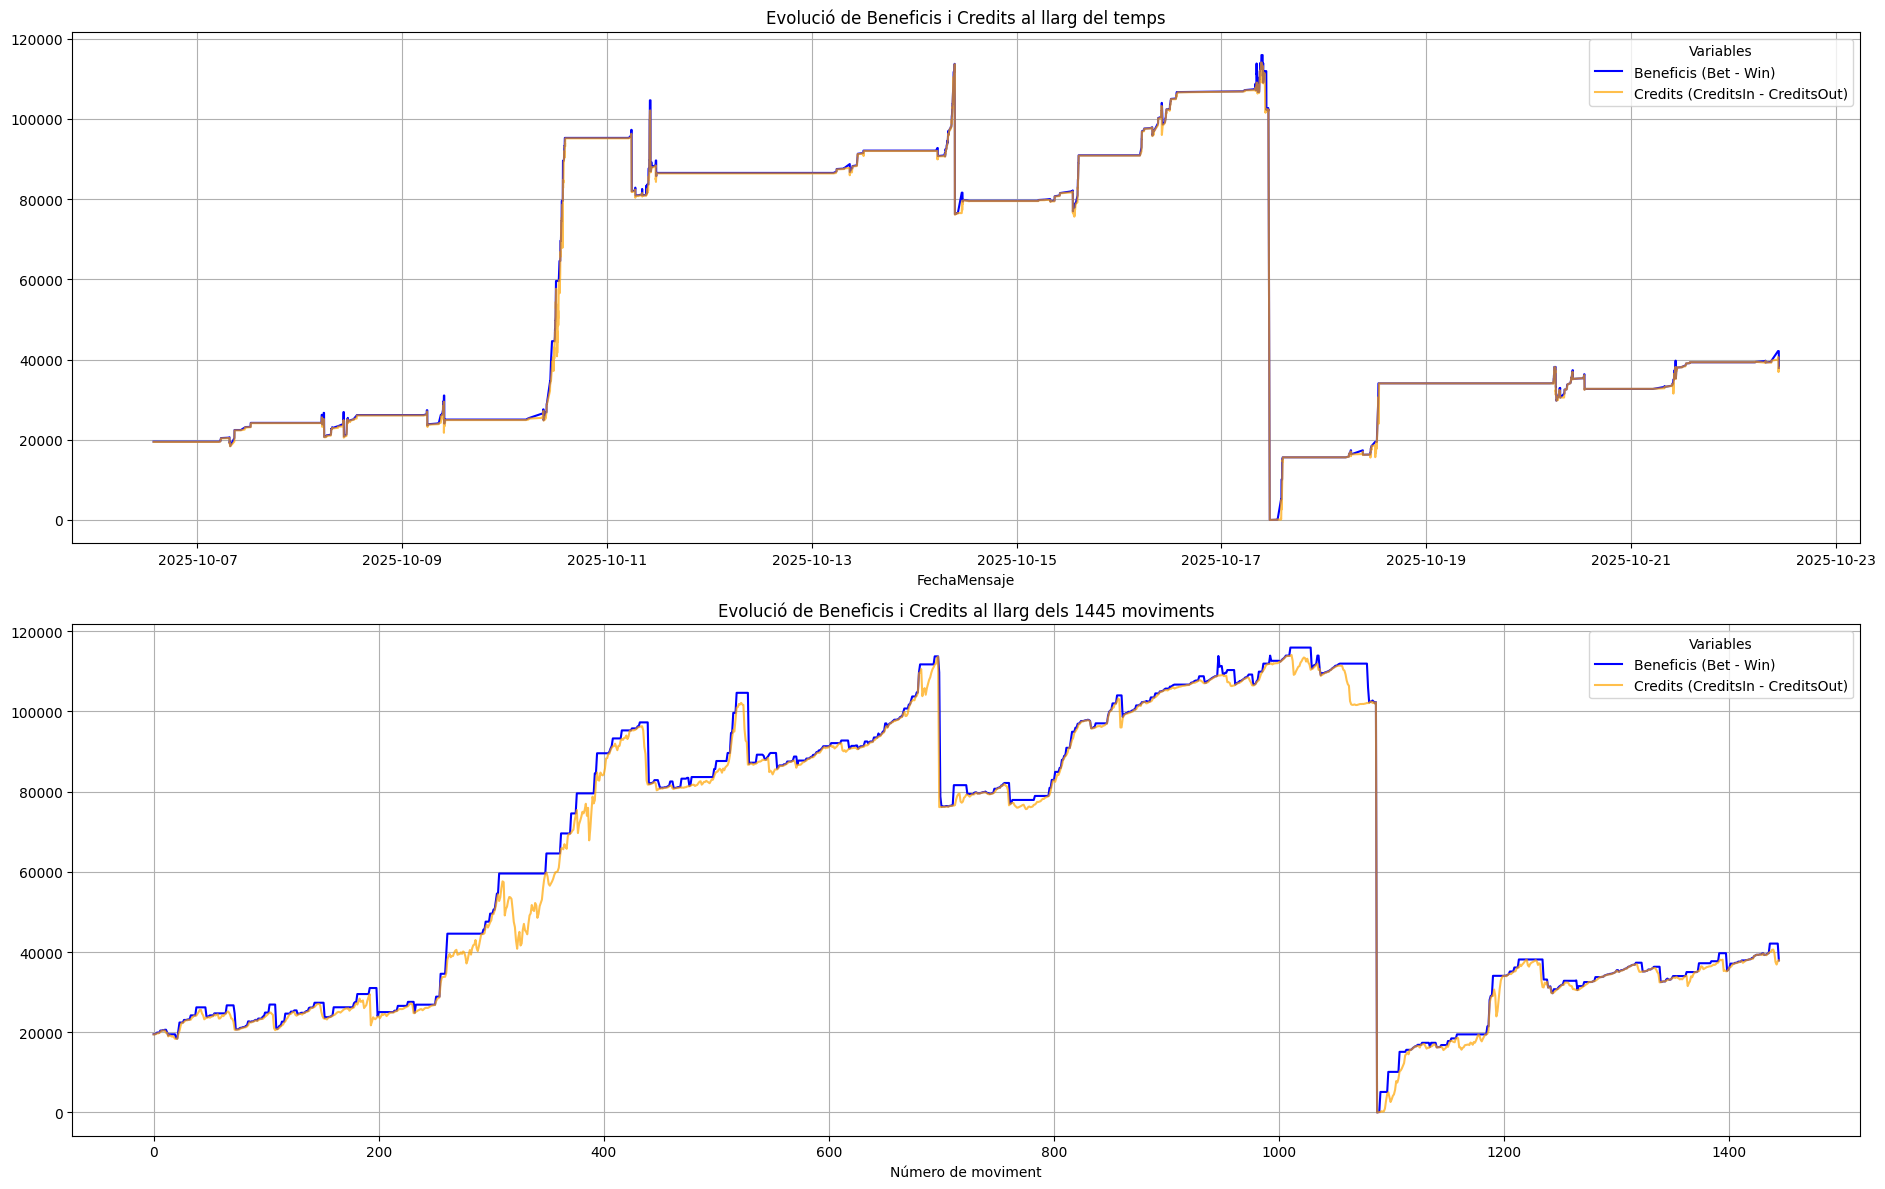


Analitzant màquina: NOG2.57104.20.csv


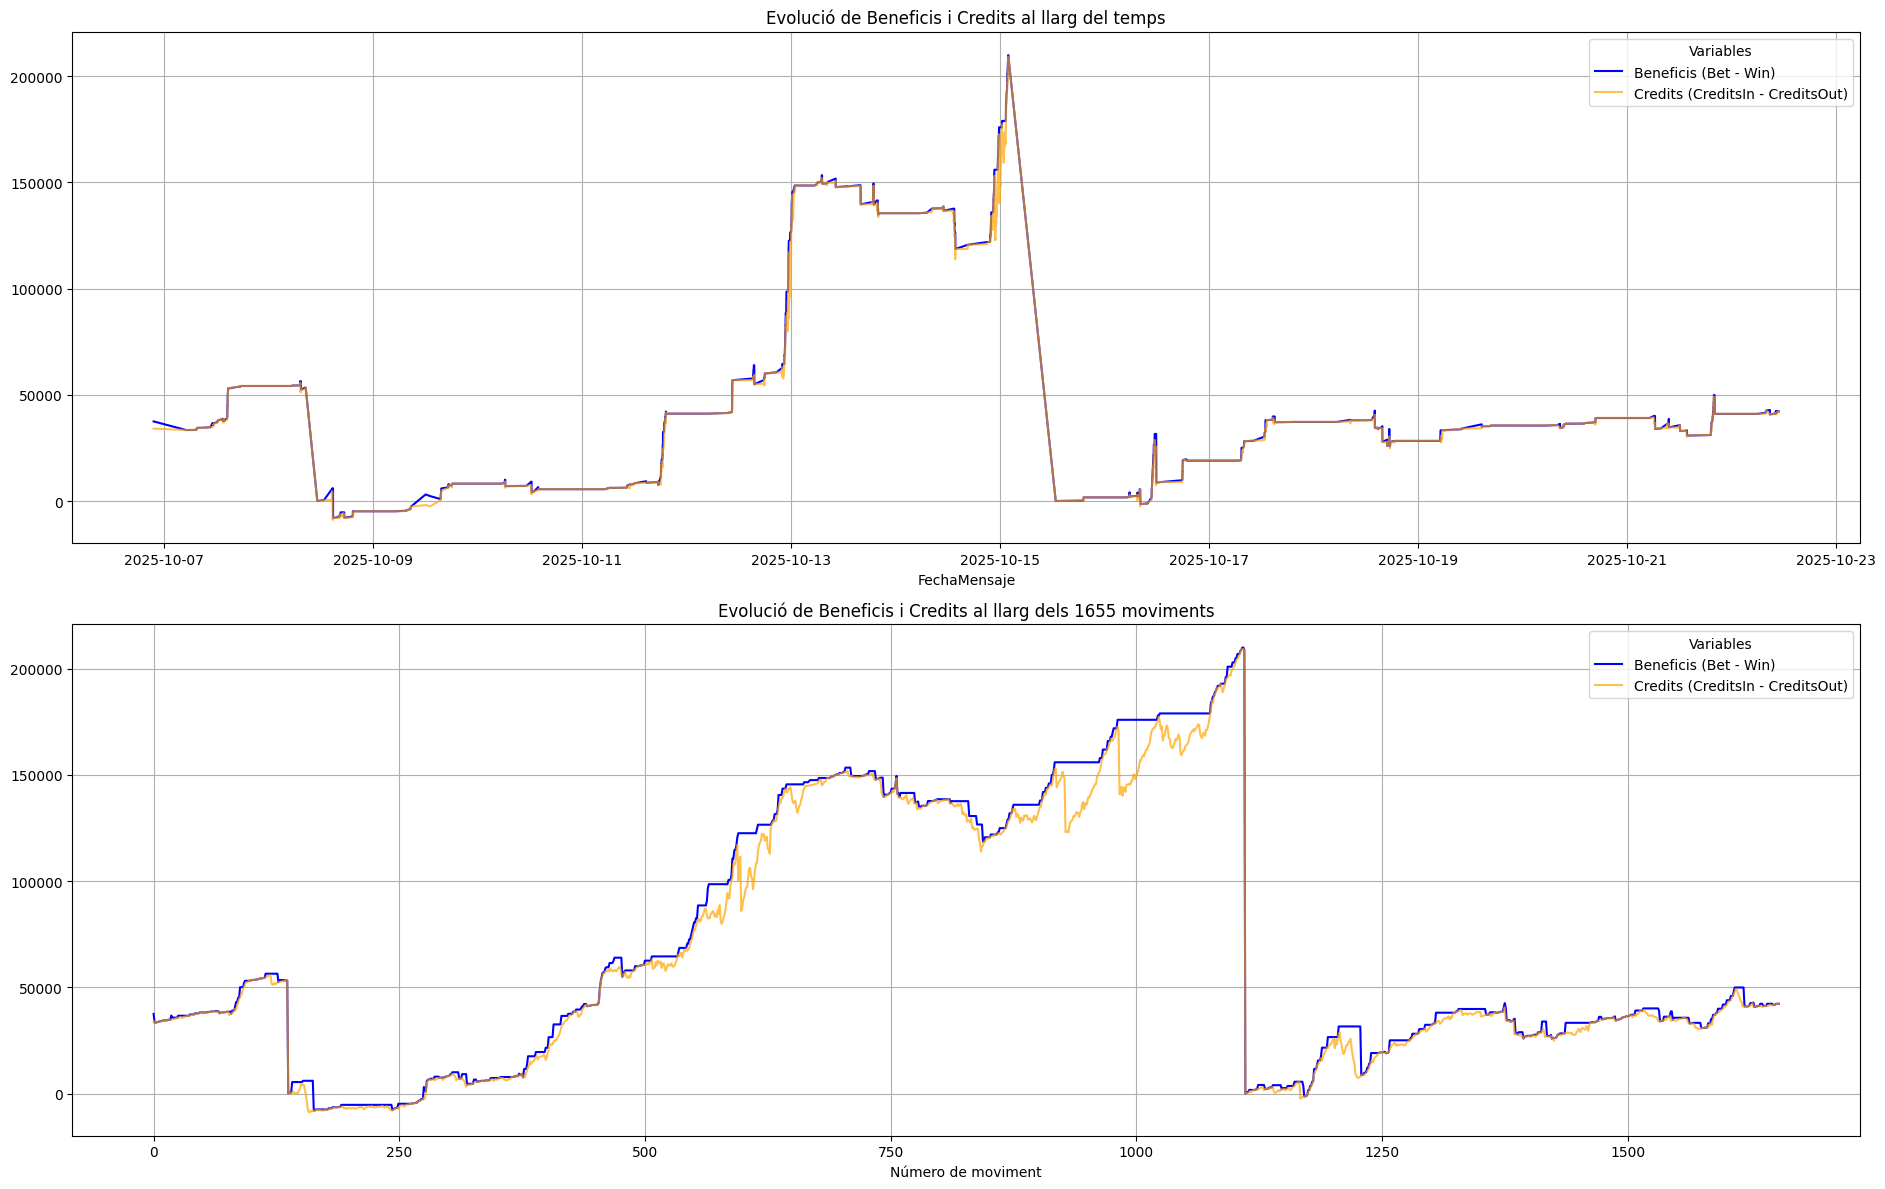


Analitzant màquina: MRE2.2469.23.csv


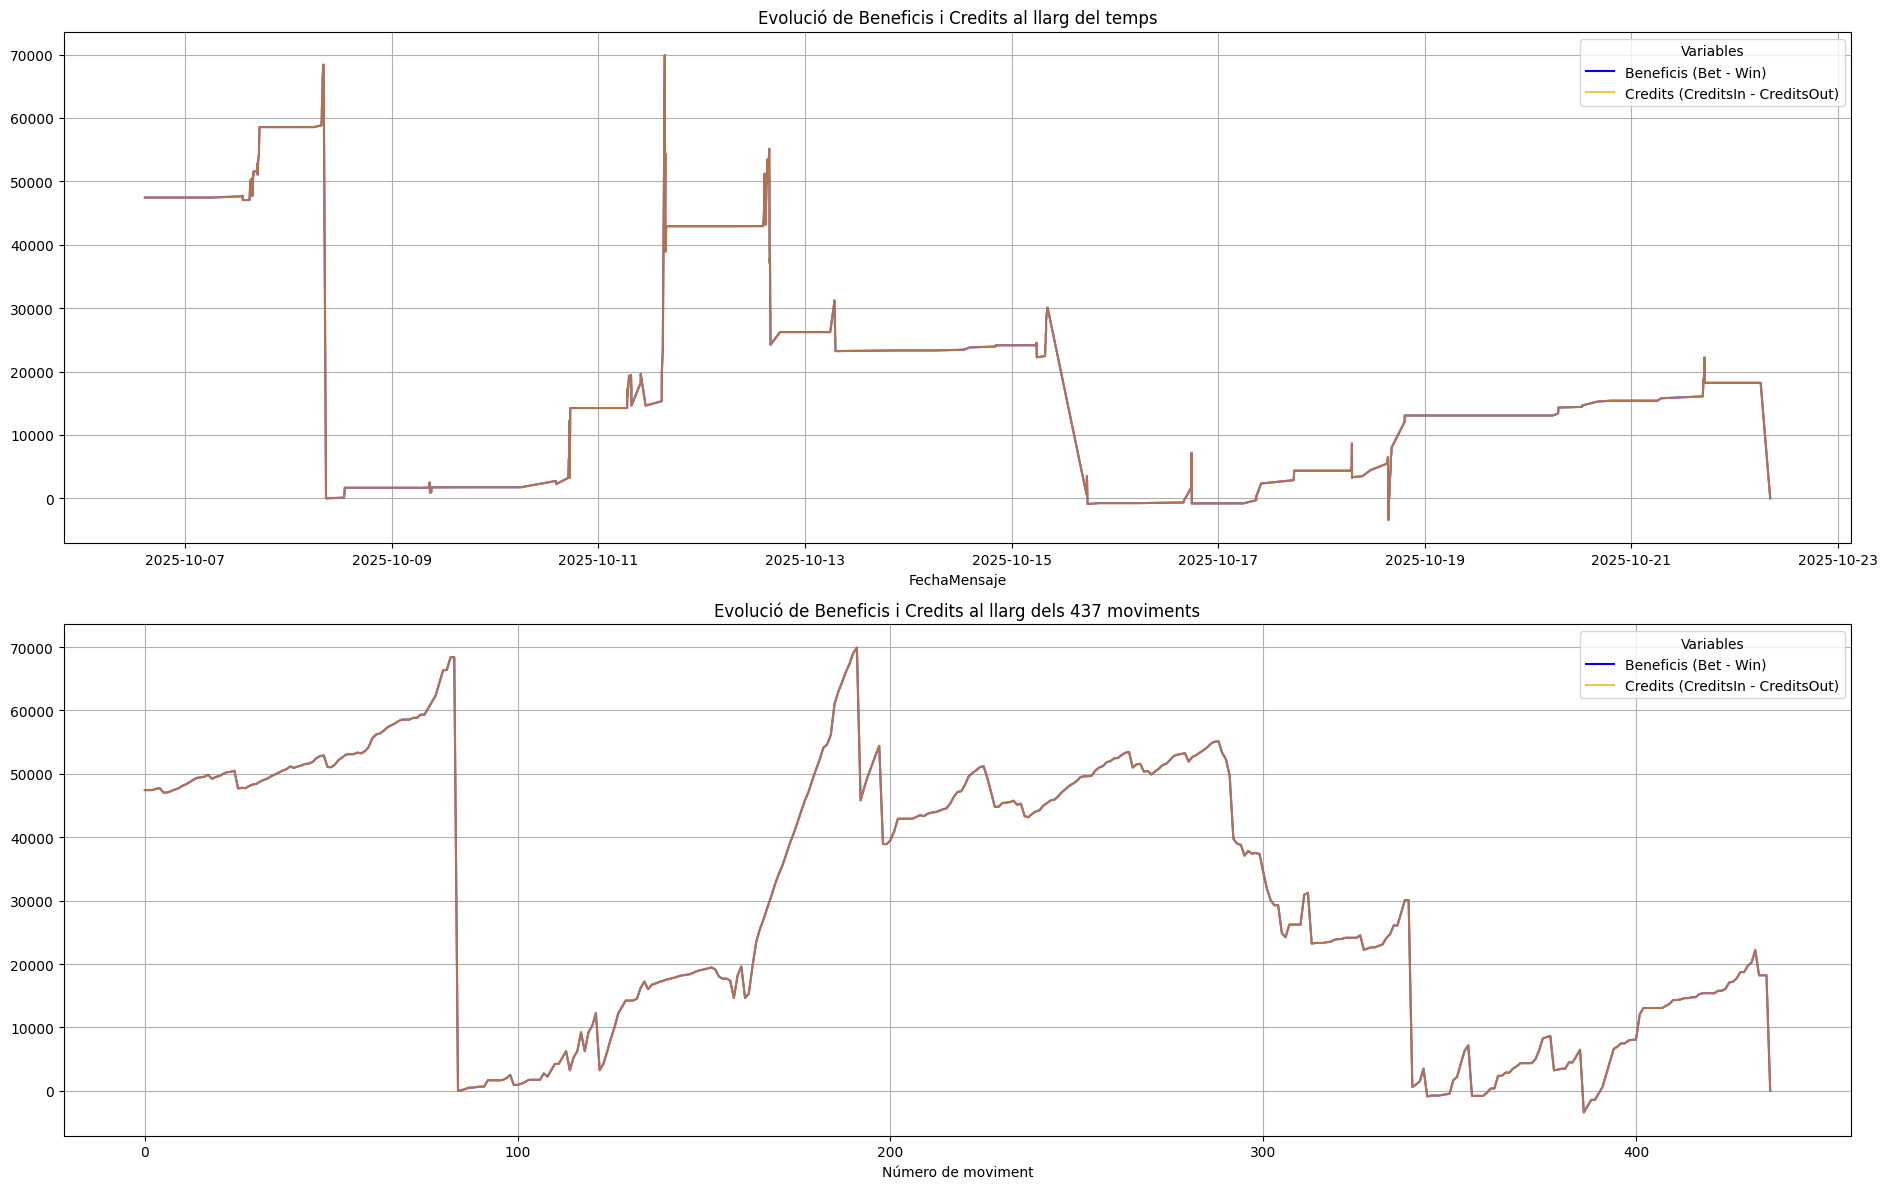


Analitzant màquina: SEL3.108132.24.csv


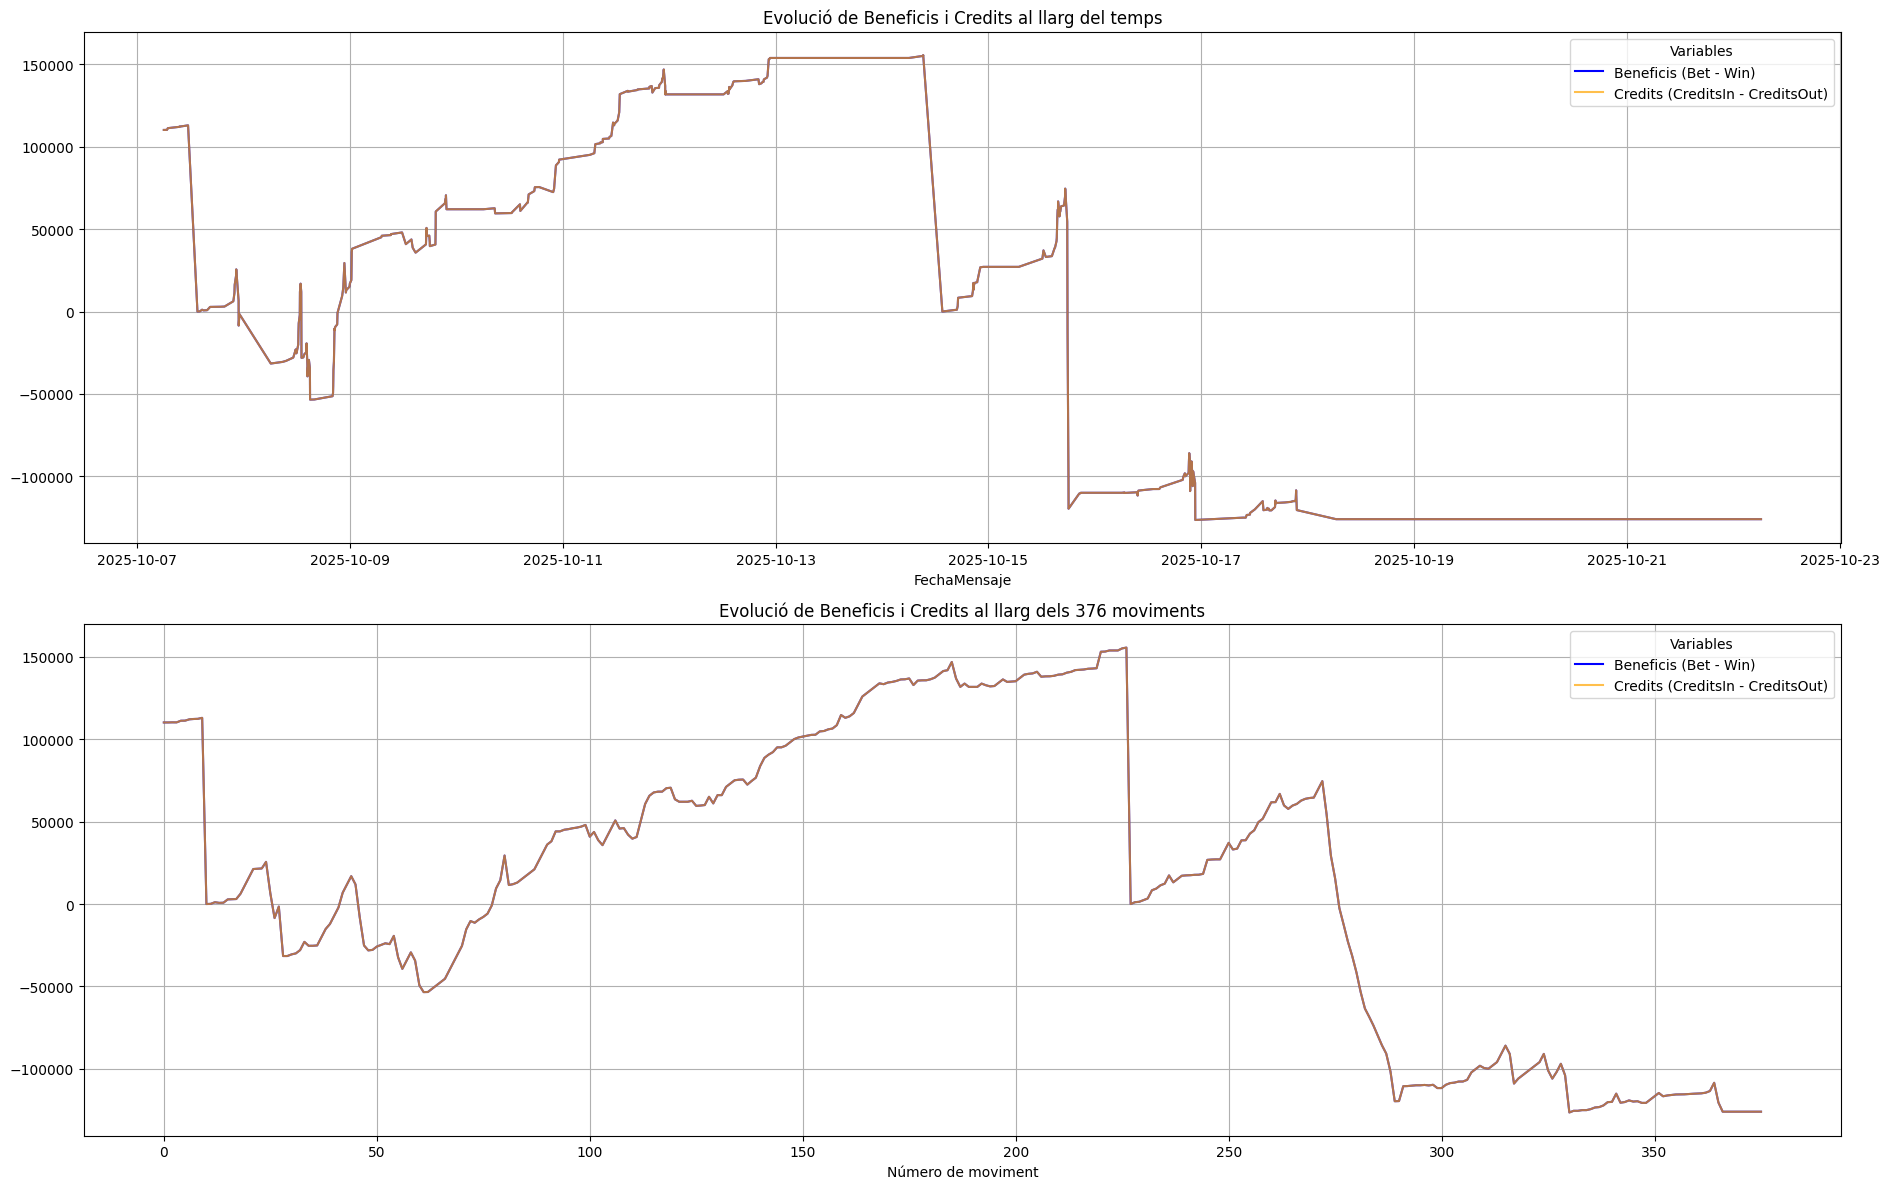


Analitzant màquina: NLR2.5493.23.csv


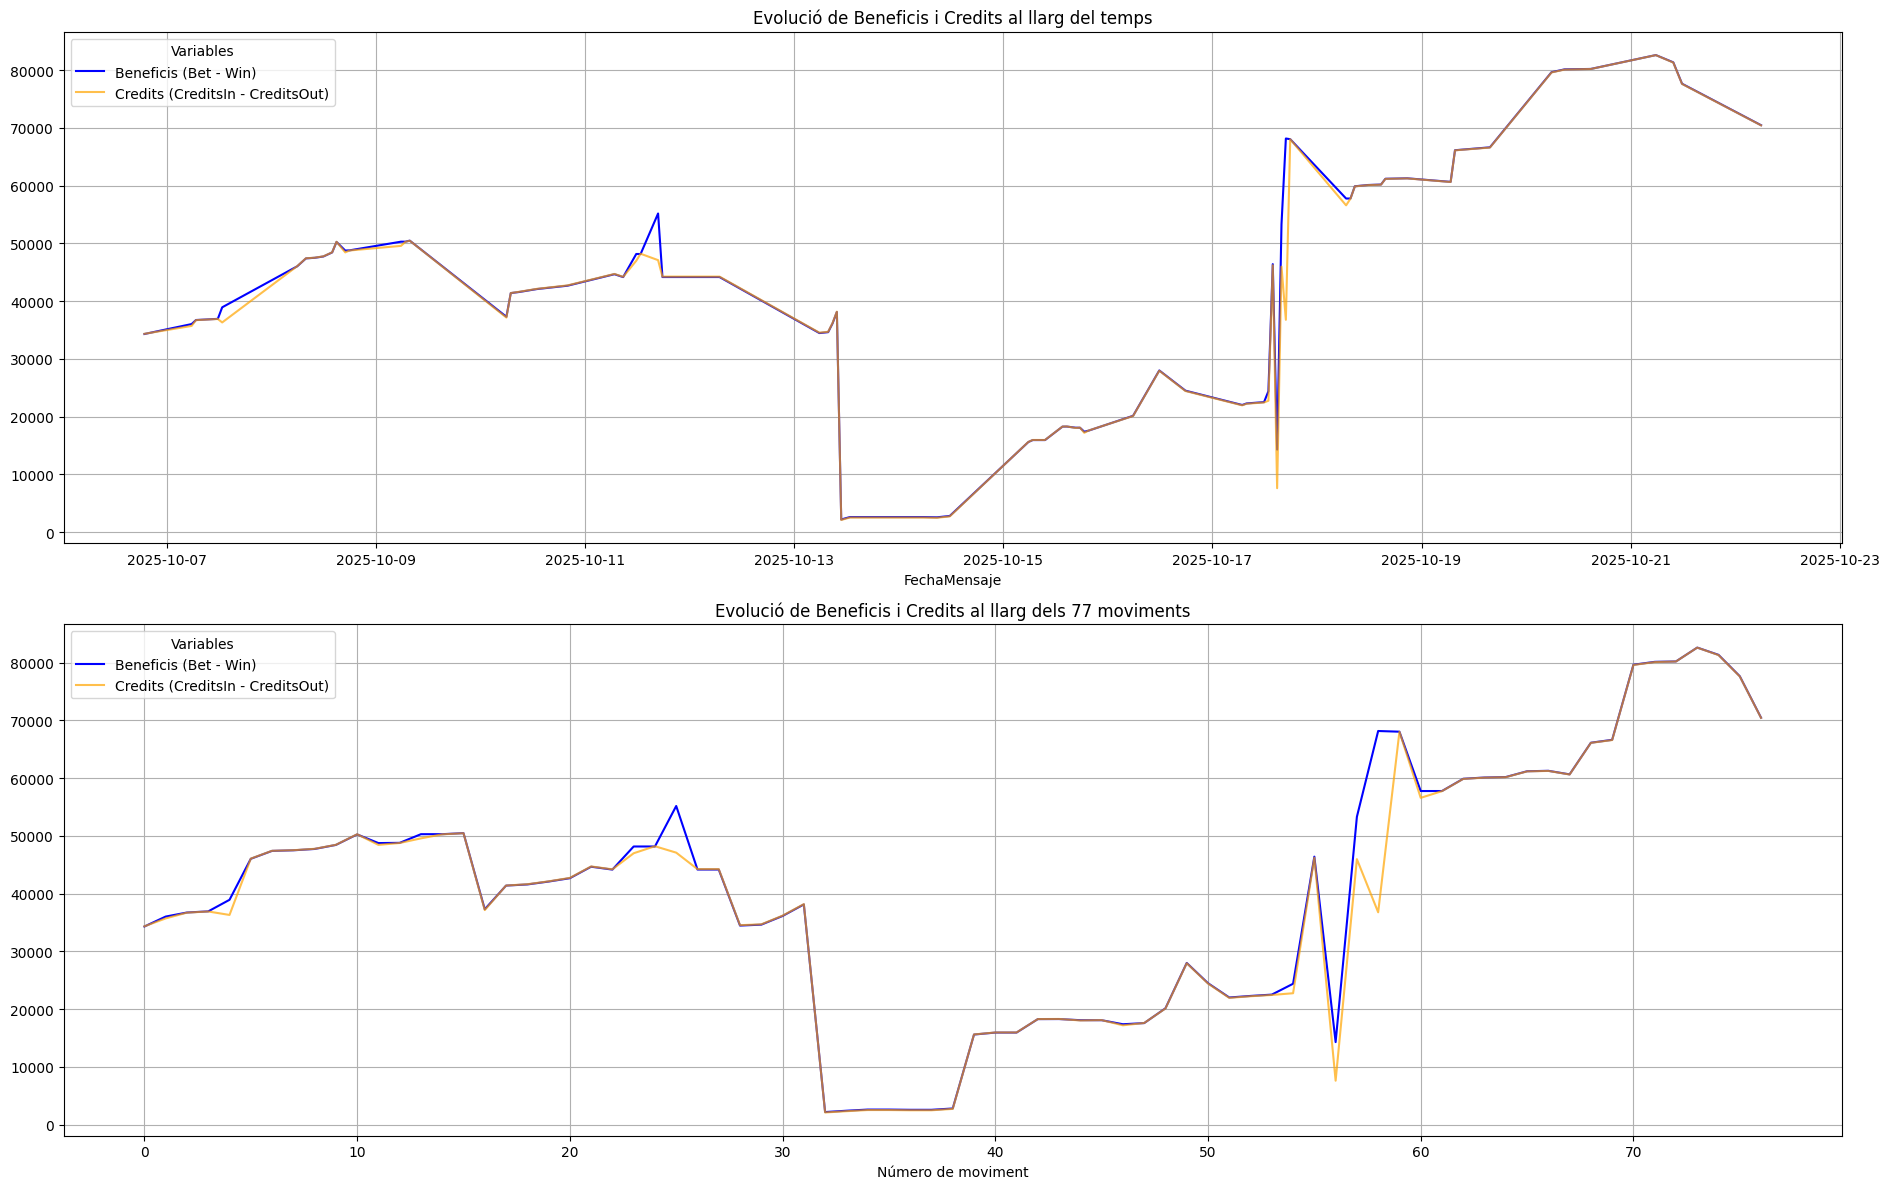

In [16]:
data_folder=os.path.join(os.path.dirname(os.getcwd()), 'data', 'Missatges_x_maquina')

# randomly select 20 file paths from data_folder
filepaths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
filepaths_sample = np.random.choice(filepaths, size=20, replace=False)
for filepath in filepaths_sample:
    #print f"\nAnalitzant màquina: and the machine name extracted from the filepath
    print(f"\nAnalitzant màquina: {os.path.basename(filepath)}")    
    eda = EDAinicial(filepath)
    #eda.plot_bet_win()
    eda.plot_beneficis_credits()